In [1]:
from IPython.core.display import display, HTML, Markdown
display(HTML("<style>.container { width:98% !important; }</style>"))

In [2]:
%matplotlib inline

In [3]:
import re
import os
import sys
import json
import math
import collections
import geoip2.database
import geoip2.errors
from cachetools import cached
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import tldextract
import requests
import netaddr
import datetime
import functools
from email_security_providers import *
import gzip
import networkx as nx
from cidr_trie import PatriciaTrie

try:
    import pygraphviz
    from networkx.drawing.nx_agraph import graphviz_layout
except ImportError:
    try:
        import pydot
        from networkx.drawing.nx_pydot import graphviz_layout
    except ImportError:
        raise ImportError("This example needs Graphviz and either "
                          "PyGraphviz or pydot")

In [4]:
start_time = datetime.datetime.now()

In [5]:
gcp_ips = requests.get('http://www.gstatic.com/ipranges/cloud.json').json()
gcp_ips = [(rec['ipv4Prefix'], '{} ({})'.format(rec['service'], rec['scope'])) for rec in gcp_ips['prefixes'] if 'ipv4Prefix' in rec]
gcp_ips = dict(gcp_ips)
gcp_ips = netaddr.IPSet(gcp_ips.keys())

In [6]:
aws_ips = requests.get('https://ip-ranges.amazonaws.com/ip-ranges.json').json()
aws_ips = [(rec['ip_prefix'], '{} ({})'.format(rec['service'], rec['region'])) for rec in aws_ips['prefixes'] if 'ip_prefix' in rec]
aws_ips = dict(aws_ips)
aws_ips = netaddr.IPSet(aws_ips.keys())

In [7]:
# https://www.microsoft.com/en-us/download/confirmation.aspx?id=56519
azure_ips = json.load(open('data/ServiceTags_Public_20200601.json'))
azure_ips = [(rec['properties']['addressPrefixes'], '{}'.format(rec['properties']['platform'])) for rec in azure_ips['values']]
azure_ips = [(ip, note) for ips, note in azure_ips for ip in ips]
azure_ips = dict(azure_ips)
azure_ips = netaddr.IPSet(azure_ips.keys())

In [8]:
@cached(cache={})
def is_azure(ip):
    return ip is not None and ip in azure_ips

@cached(cache={})
def is_aws(ip):
    return ip is not None and ip in aws_ips

@cached(cache={})
def is_gcp(ip):
    return ip is not None and ip in gcp_ips

In [9]:
maxmind_asn = geoip2.database.Reader('GeoLite2-ASN_20200616/GeoLite2-ASN.mmdb')
maxmind_city = geoip2.database.Reader('GeoLite2-City_20200616/GeoLite2-City.mmdb')

alexa = dict([(domain, int(rank)) for (rank, domain) in [line.strip().split(',', 1) for line in open('data/top-1m.csv')]])

@cached(cache={})
def maxmind(ip):
    result = {'ip': ip}

    try:
        record = maxmind_asn.asn(ip)
        result['asn'] = record.autonomous_system_number
        result['asname'] = record.autonomous_system_organization
    except geoip2.errors.AddressNotFoundError:
        result['asn'] =  None
        result['asname'] = None

    try: 
        record = maxmind_city.city(ip)
        result['cc'] = record.country.iso_code
        result['country'] = record.country.name
        result['city'] = record.city.name
    except geoip2.errors.AddressNotFoundError:
        result['cc'] = None
        result['country'] = None
        result['city'] = None
    
    return result

In [10]:
df = pd.DataFrame([json.loads(line) for line in open('spf-linked-all-registered-domains.json')]).fillna('')

In [11]:
df['domain_alexa_rank'] = df.domain.map(alexa).fillna(-1)

In [12]:
def maxmind_wrapper(cidr):
    ip = cidr
    if '/' in cidr:
        ip = cidr.split('/')[0]
    if re.search(r'^\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}$', ip):
        try:
            return maxmind(ip)
        except:
            pass
    return {}

In [13]:
df['maxmind'] = df.ips.map(lambda ips: [maxmind_wrapper(ip) for ip in ips])
df['maxmind_asnames'] = df.maxmind.map(lambda maxminds: set([rec.get('asname') for rec in maxminds if rec.get('asname')]))

In [14]:
def safe_registered_domain(domain):
    try:
        return tldextract.extract(domain).registered_domain
    except:
        return ''

df['includes_registered_domains'] = df.includes.map(
    lambda domains: set([safe_registered_domain(domain) for domain in domains])
)
    
df['includes_providers'] = df.includes_registered_domains.map(
    lambda includes_registered_domains: set(
        [
            provider for provider in [email_provider_domains.get(domain) for domain in includes_registered_domains] if provider
        ]
    )
)
df['maxmind_asname_providers'] = df.maxmind_asnames.map(lambda asnames: set([provider for provider in [email_provider_asns.get(asname) for asname in asnames] if provider]))
df['email_security_providers'] = [incl_p|asn_p for incl_p,asn_p in zip(df.includes_providers, df.maxmind_asname_providers)]
df['num_email_security_providers'] = df.email_security_providers.map(lambda email_security_providers: len(email_security_providers))

In [15]:
#TODO: consider refactoring below to make this more efficient (creating lots of netaddr.IPNetwork now...)

In [16]:
def safe_network_size(ip):
    try:
        return netaddr.IPNetwork(ip).size
    except:
        return 0
df['ips_size'] = df.ips.map(lambda ips: sum([safe_network_size(ip) for ip in ips]))

In [17]:
def public_networks(ips):
    results = []
    for ip in ips:
        try:
            netw = netaddr.IPNetwork(ip)
            if not netw.is_reserved() and not netw.is_private() and not netw.is_link_local():
                results.append(netw)
        except:
            pass
    return results

df['public_networks'] = df.ips.map(public_networks)
df['public_networks_size'] = df.public_networks.map(lambda networks: sum([netw.size for netw in networks]))
largest_networks = df.public_networks.map(lambda networks: max([(netw.size, netw) for netw in networks]) if networks else (0,'',))
df['largest_public_network_size'] = largest_networks.map(lambda net_tuple: net_tuple[0])
df['largest_public_network']      = largest_networks.map(lambda net_tuple: net_tuple[1])

In [18]:
def safe_largest_network(ips):
    results = []
    for ip in ips:
        try:
            netw = netaddr.IPNetwork(ip)
            results.append((netw.size, str(netw),))
        except:
            pass
    if len(results) > 0:
        return max(results)
    else:
        return 0, ''

largest_networks = df.ips.map(safe_largest_network)
df['largest_network_size'] = largest_networks.map(lambda net_tuple: net_tuple[0])
df['largest_network'] = largest_networks.map(lambda net_tuple: net_tuple[1])

In [19]:
def safe_ip_lookup(ips, func):
    results = []
    for ip in ips:
        try:
            if func(ip):
                results.append(ip)
        except:
            pass
    return results

df['aws_networks'] = df.ips.map(lambda ips: safe_ip_lookup(ips, is_aws))
df['azure_networks'] = df.ips.map(lambda ips: safe_ip_lookup(ips, is_azure))
df['gcp_networks'] = df.ips.map(lambda ips: safe_ip_lookup(ips, is_gcp))

df['aws_networks_size'] = df.aws_networks.map(lambda ips: sum([netaddr.IPNetwork(ip).size for ip in ips]))
df['azure_networks_size'] = df.azure_networks.map(lambda ips: sum([netaddr.IPNetwork(ip).size for ip in ips]))
df['gcp_networks_size'] = df.gcp_networks.map(lambda ips: sum([netaddr.IPNetwork(ip).size for ip in ips]))

df['is_aws'] = df.aws_networks_size.map(lambda size: size > 0)
df['is_azure'] = df.azure_networks_size.map(lambda size: size > 0)
df['is_gcp'] = df.gcp_networks_size.map(lambda size: size > 0)

In [20]:
df[df.is_azure]

domain  \
55                   ltk.dk   
64       caboazulresort.com   
121      castellicafe.co.uk   
173                 sei.org   
202      store-raycassin.jp   
...                     ...   
3322427       plusit.com.au   
3322636           aceds.org   
3322825       diepenbeek.be   
3323040            smlb.com   
3323212       bpdeurope.com   

                                                  includes  \
55       [_spf.essenslms.com, spf.protection.outlook.co...   
64       [spf.protection.outlook.com, spf-003cb701.ppho...   
121      [servers.mcsv.net, spf.protection.outlook.com,...   
173      [authsmtp.com, servers.mcsv.net, spf.protectio...   
202                     [spf.ecbeing.co.jp, spf.q-send.jp]   
...                                                    ...   
3322427  [spf.protection.outlook.com, spf.emailsignatur...   
3322636  [spf.protection.outlook.com, 2220094.spf01.hub...   
3322825  [spf.ciport.be, spf.facilitator.e2e.be, spf.pr...   
3323040  [smtp.smlb.com, spf.cloud.vadesecure.com, spf....   
3323212  [_spf.salesforce.com, spf.signhost.com, spf.pr...   

                                                       ips  domain_alexa_rank  \
55       [213.174.69.253/32, 83.149.98.72, 62.204.93.13...               -1.0   
64       [104.47.0.0/17, 40.107.0.0/16, 23.96.254.246, ...               -1.0   
121      [81.29.66.187, 13.81.10.179, 52.232.131.215, 4...               -1.0   
173      [198.2.128.0/18, 104.47.0.0/17, 40.107.0.0/16,...           768998.0   
202      [210.148.197.0/24, 210.140.160.0/20, 210.129.5...               -1.0   
...                                                    ...                ...   
3322427  [104.47.0.0/17, 40.107.0.0/16, 144.139.81.222,...               -1.0   
3322636  [18.132.189.127, 52.16.75.109, 54.79.0.4, 54.1...               -1.0   
3322825  [193.190.120.69, 13.81.10.179, 52.232.131.215,...               -1.0   
3323040  [52.143.133.92/32, 104.47.0.0/17, 40.107.0.0/1...               -1.0   
3323212  [93.94.228.0/24, 13.81.211.35/32, 185.46.180.3...               -1.0   

                                                   maxmind  \
55       [{'ip': '213.174.69.253', 'asn': 44398, 'asnam...   
64       [{'ip': '104.47.0.0', 'asn': 8075, 'asname': '...   
121      [{'ip': '81.29.66.187', 'asn': 24931, 'asname'...   
173      [{'ip': '198.2.128.0', 'asn': 14782, 'asname':...   
202      [{'ip': '210.148.197.0', 'asn': 2497, 'asname'...   
...                                                    ...   
3322427  [{'ip': '104.47.0.0', 'asn': 8075, 'asname': '...   
3322636  [{'ip': '18.132.189.127', 'asn': 16509, 'asnam...   
3322825  [{'ip': '193.190.120.69', 'asn': 2611, 'asname...   
3323040  [{'ip': '52.143.133.92', 'asn': 8075, 'asname'...   
3323212  [{'ip': '93.94.228.0', 'asn': 25151, 'asname':...   

                                           maxmind_asnames  \
55       {LEASEWEB-USA-WDC, KMD A/S, Nianet A/S, Tele D...   
64       {PROOFPOINT-ASN-US-EAST, MICROSOFT-CORP-MSN-AS...   
121      {THEROCKETSCIENCEGROUP, MICROSOFT-CORP-MSN-AS-...   
173      {THEROCKETSCIENCEGROUP, MICROSOFT-CORP-MSN-AS-...   
202      {IDC Frontier Inc., MICROSOFT-CORP-MSN-AS-BLOC...   
...                                                    ...   
3322427  {Telstra Corporation Ltd, MICROSOFT-CORP-MSN-A...   
3322636  {AMAZON-AES, MICROSOFT-CORP-MSN-AS-BLOCK, AMAZ...   
3322825  {MICROSOFT-CORP-MSN-AS-BLOCK, BELNET, Kangaroo...   
3323040  {MICROSOFT-CORP-MSN-AS-BLOCK, Online S.a.s., C...   
3323212  {Cyso Group B.V., Basefarm AS, MICROSOFT-CORP-...   

                               includes_registered_domains includes_providers  \
55       {hostedsepo.dk, topdesk.net, outlook.com, true...                 {}   
64       {emailsignatures365.com, outlook.com, pphosted...       {Proofpoint}   
121        {emailsignatures365.com, outlook.com, mcsv.net}                 {}   
173      {outlook.com, emailsignatures365.com, authsmtp...                 {}   
202                             {ec

In [21]:
df[df.is_aws]

domain  \
18                climpact.ch   
29       mtt136yvonmartel.com   
55                     ltk.dk   
65                akaipro.com   
74                  tefiti.nl   
...                       ...   
3323176         luciefelix.fr   
3323190    britishparts.co.uk   
3323195  kosciuskohabitat.com   
3323205    prettypursuits.com   
3323213         erikbruce.com   

                                                  includes  \
18                                     [spf.infomaniak.ch]   
29                                                      []   
55       [_spf.essenslms.com, spf.protection.outlook.co...   
65       [devmail.inmusicbrands.com, icpbound.com, spf....   
74                                        [spf.dmrmail.nl]   
...                                                    ...   
3323176                                [spf.infomaniak.ch]   
3323190  [ranges.visualsoft.co.uk, _spf.google.com, ran...   
3323195         [bluehost.com, spf.protection.outlook.com]   
3323205                                     [bluehost.com]   
3323213                   [_spf.google.com, amazonses.com]   

                                                       ips  domain_alexa_rank  \
18       [45.157.188.20/30, 84.16.68.109, 76.223.176.0/...               -1.0   
29                                          [52.3.112.235]               -1.0   
55       [213.174.69.253/32, 83.149.98.72, 62.204.93.13...               -1.0   
65       [98.191.12.242, 50.57.84.184, 207.246.242.252,...            38336.0   
74       [3.121.240.20, 18.156.160.6, 35.157.26.68, 18....               -1.0   
...                                                    ...                ...   
3323176  [45.157.188.20/30, 84.16.68.109, 76.223.176.0/...               -1.0   
3323190  [46.236.38.128/25, 46.236.41.0/24, 81.29.79.0/...               -1.0   
3323195  [185.189.236.0/22, 67.20.64.0/18, 52.222.73.12...               -1.0   
3323205  [185.189.236.0/22, 67.20.64.0/18, 52.222.73.12...               -1.0   
3323213  [76.223.176.0/20, 23.251.224.0/19, 54.240.0.0/...               -1.0   

                                                   maxmind  \
18       [{'ip': '45.157.188.20', 'asn': 29222, 'asname...   
29       [{'ip': '52.3.112.235', 'asn': 14618, 'asname'...   
55       [{'ip': '213.174.69.253', 'asn': 44398, 'asnam...   
65       [{'ip': '98.191.12.242', 'asn': 22773, 'asname...   
74       [{'ip': '3.121.240.20', 'asn': 16509, 'asname'...   
...                                                    ...   
3323176  [{'ip': '45.157.188.20', 'asn': 29222, 'asname...   
3323190  [{'ip': '46.236.38.128', 'asn': 24931, 'asname...   
3323195  [{'ip': '185.189.236.0', 'asn': 200069, 'asnam...   
3323205  [{'ip': '185.189.236.0', 'asn': 200069, 'asnam...   
3323213  [{'ip': '76.223.176.0', 'asn': 16509, 'asname'...   

                                           maxmind_asnames  \
18                      {Infomaniak Network SA, AMAZON-02}   
29                                            {AMAZON-AES}   
55       {LEASEWEB-USA-WDC, KMD A/S, Nianet A/S, Tele D...   
65       {IRONPORT-SYSTEMS-INC, MICROSOFT-CORP-MSN-AS-B...   
74                                             {AMAZON-02}   
...                                                    ...   
3323176                 {Infomaniak Network SA, AMAZON-02}   
3323190                       {Pulsant Limited, AMAZON-02}   
3323195  {Amazon Data Services Ireland Ltd, UNIFIEDLAYE...   
3323205  {Amazon Data Services Ireland Ltd, UNIFIEDLAYE...   
3323213                                        {AMAZON-02}   

                               includes_registered_domains includes_providers  \
18                                         {infomaniak.ch}                 {}   
29                                                      {}                 {}   
55       {hostedsepo.dk, topdesk.net, outlook.com, true...                 {}   
65          {icpbound.com, outlook.com, inmusicbrands.com}                 {}   
74           

In [22]:
df[df.is_gcp]

domain  \
14              varrojoanna.com   
15                      smm.org   
47       fullstopaccounts.co.uk   
177           pimentocheese.com   
226           finishlineusa.com   
...                         ...   
3323023              ragtag.org   
3323055      terralogixcorp.com   
3323148       southernshirt.com   
3323215       torontonews24.com   
3323218     kristoferbuckle.com   

                                                  includes  \
14                                       [_spf.google.com]   
15       [_spf.google.com, _spf.atlassian.net, shops.sh...   
47       [_spf.google.com, infusionmail.com, squarespac...   
177                                    [shops.shopify.com]   
226      [_spf.cleverconcepts.net, spf.protection.outlo...   
...                                                    ...   
3323023  [shops.shopify.com, _spf.google.com, servers.m...   
3323055                      [_spf.mailspamprotection.com]   
3323148  [spf.mandrillapp.com, servers.mcsv.net, shops....   
3323215                      [_spf.mailspamprotection.com]   
3323218                 [icpbounce.com, shops.shopify.com]   

                                                       ips  domain_alexa_rank  \
14                                        [35.214.151.218]               -1.0   
15       [35.185.32.98, 35.227.50.232, 35.226.186.69, 3...           246496.0   
47       [35.227.130.0/24, 142.0.181.0/28, 142.0.186.13...               -1.0   
177      [35.185.32.98, 35.227.50.232, 35.226.186.69, 3...               -1.0   
226      [104.47.0.0/17, 40.107.0.0/16, 35.203.175.58, ...               -1.0   
...                                                    ...                ...   
3323023  [35.185.32.98, 35.227.50.232, 35.226.186.69, 5...               -1.0   
3323055                                    [35.213.158.34]               -1.0   
3323148  [35.185.32.98, 198.2.132.0/22, 35.226.186.69, ...               -1.0   
3323215                    [181.224.154.34, 35.209.62.152]               -1.0   
3323218  [35.185.32.98, 35.227.50.232, 35.226.186.69, 2...               -1.0   

                                                   maxmind  \
14       [{'ip': '35.214.151.218', 'asn': 19527, 'asnam...   
15       [{'ip': '35.185.32.98', 'asn': 15169, 'asname'...   
47       [{'ip': '35.227.130.0', 'asn': 15169, 'asname'...   
177      [{'ip': '35.185.32.98', 'asn': 15169, 'asname'...   
226      [{'ip': '104.47.0.0', 'asn': 8075, 'asname': '...   
...                                                    ...   
3323023  [{'ip': '35.185.32.98', 'asn': 15169, 'asname'...   
3323055  [{'ip': '35.213.158.34', 'asn': 19527, 'asname...   
3323148  [{'ip': '35.185.32.98', 'asn': 15169, 'asname'...   
3323215  [{'ip': '181.224.154.34', 'asn': 32475, 'asnam...   
3323218  [{'ip': '35.185.32.98', 'asn': 15169, 'asname'...   

                                           maxmind_asnames  \
14                                              {GOOGLE-2}   
15                                       {ASN-SMM, GOOGLE}   
47       {SQUARESPACE, SOCKETLABS, LNH-INC, RACKSPACE, ...   
177                                {SINGLEHOP-LLC, GOOGLE}   
226                  {MICROSOFT-CORP-MSN-AS-BLOCK, GOOGLE}   
...                                                    ...   
3323023         {THEROCKETSCIENCEGROUP, AMAZON-02, GOOGLE}   
3323055                                         {GOOGLE-2}   
3323148                    {THEROCKETSCIENCEGROUP, GOOGLE}   
3323215                          {GOOGLE-2, SINGLEHOP-LLC}   
3323218  {PR-NEWSWIRE-USA-1, AS-TIERP-7349, LVLT-3549, ...   

                               includes_registered_domains includes_providers  \
14                                            {google.com}                 {}   
15                {atlassian.net, shopify.com, google.com}                 {}   
47       {squarespace-mail.com, infusionmail.com, googl...                 {}   
177                                          {shopify.com}              

In [23]:
df[df['maxmind_asname_providers'].map(lambda p: len(p) > 2)]

domain  \
8257                                               syb.com   
31765    _p.1.18kecw3._u.cheetahdigital.com._spf.smart....   
32514                                         octanner.com   
115073                                          fsbnh.bank   
119446                                       techstyle.com   
...                                                    ...   
3158028  _p.2.18kecw3._u.cheetahdigital.com._spf.smart....   
3177668                          _s000149761.autospf.email   
3272482                                          ptcvt.com   
3275751  _p.3.18kecw3._u.cheetahdigital.com._spf.smart....   
3307371                                     edftrading.com   

                                                  includes  \
8257     [spf.protection.outlook.com, spf.webaccess1.co...   
31765    [_p.2.18kecw3._u.cheetahdigital.com._spf.smart...   
32514    [spf.protection.outlook.com, _spf.31326.transa...   
115073                         [_spf.wte.net, dnsexit.com]   
119446              [servers.mcsv.net, spf1.techstyle.com]   
...                                                    ...   
3158028  [_p.3.18kecw3._u.cheetahdigital.com._spf.smart...   
3177668                        [_s000149762.autospf.email]   
3272482  [spf.constantcontact.com, spf.cocci.com, _spf....   
3275751  [_p.4.18kecw3._u.cheetahdigital.com._spf.smart...   
3307371         [_u.edftrading.com._spf.smart.ondmarc.com]   

                                                       ips  domain_alexa_rank  \
8257     [207.46.101.128/26, 157.56.110.0/23, 192.0.56....               -1.0   
31765    [72.35.12.0/24, 198.21.4.52, 23.253.197.137, 1...               -1.0   
32514    [13.81.10.179, 198.2.132.0/22, 52.232.131.215,...               -1.0   
115073   [192.3.61.247, 168.245.0.0/17, 208.66.22.0/24,...           307366.0   
119446   [184.173.153.0/24, 209.11.206.128/25, 207.211....               -1.0   
...                                                    ...                ...   
3158028  [72.35.12.0/24, 198.21.4.52, 23.253.197.137, 1...               -1.0   
3177668  [209.34.255.251, 172.217.32.0/20, 65.205.252.0...               -1.0   
3272482  [10.67.23.0/24, 119.81.127.203, 130.248.173.0/...               -1.0   
3275751  [198.21.4.52, 23.253.197.137, 167.89.64.9, 213...               -1.0   
3307371  [213.167.81.0/25, 155.56.68.128/26, 167.216.12...               -1.0   

                                                   maxmind  \
8257     [{'ip': '207.46.101.128', 'asn': 8075, 'asname...   
31765    [{'ip': '72.35.12.0', 'asn': 16941, 'asname': ...   
32514    [{'ip': '13.81.10.179', 'asn': 8075, 'asname':...   
115073   [{'ip': '192.3.61.247', 'asn': 36352, 'asname'...   
119446   [{'ip': '184.173.153.0', 'asn': 36351, 'asname...   
...                                                    ...   
3158028  [{'ip': '72.35.12.0', 'asn': 16941, 'asname': ...   
3177668  [{'ip': '209.34.255.251', 'asn': 13649, 'asnam...   
3272482  [{'ip': '10.67.23.0', 'asn': None, 'asname': N...   
3275751  [{'ip': '198.21.4.52', 'asn': 11377, 'asname':...   
3307371  [{'ip': '213.167.81.0', 'asn': 60492, 'asname'...   

                                           maxmind_asnames  \
8257     {GREENVIEWDATA, CHECKFREE, MULTA-ASN1, AppRive...   
31765    {IDC Frontier Inc., ASN-INTERNAP-BLK, Equinix ...   
32514    {THEROCKETSCIENCEGROUP, LOOMISSAYLES, MICROSOF...   
115073   {GREENVIEWDATA, EONIX-COMMUNICATIONS-ASBLOCK-6...   
119446   {THEROCKETSCIENCEGROUP, NYINTERNET, COGECO-PEE...   
...                                                    ...   
3158028  {IDC Frontier Inc., ASN-INTERNAP-BLK, Equinix ...   
3177668  {THEROCKETSCIENCEGROUP, DIGITAL-INSIGHT, TWRS-...   
3272482  {GREENVIEWDATA, COCC-ISP1, AppRiver AG, LIQUID...   
3275751  {IDC Frontier Inc., ASN-INTERNAP-BLK, Equinix ...   
3307371  {THEROCKETSCIENCEGROUP, ASN-INTERNAP-BLK, Mime...   

                               includes_registered_domains  \
8257                {outlook.com, wte

In [24]:
df[df['includes_providers'].map(lambda p: len(p) > 0)]

domain  \
6            aydaacraft.online   
44             balticbright.lv   
64          caboazulresort.com   
90         blueskytraveler.com   
125           iteachers.com.au   
...                        ...   
3323177           lensmill.com   
3323186    lacuartacolumna.com   
3323187   diamondproducers.com   
3323203         alacergold.com   
3323209  anabaptistwitness.org   

                                                  includes  \
6           [spf.mx.hostinger.com, relay.mailchannels.net]   
44                                [relay.mailchannels.net]   
64       [spf.protection.outlook.com, spf-003cb701.ppho...   
90             [relay.mailchannels.net, spf.a2hosting.com]   
125                                [spf.antispamcloud.com]   
...                                                    ...   
3323177                               [spf.mailanyone.net]   
3323186                           [relay.mailchannels.net]   
3323187                                [spf.securence.com]   
3323203  [spf.constantcontact.com, mail.zendesk.com, sp...   
3323209  [spf2.mailchannels.net, spf1.mailchannels.net,...   

                                                       ips  domain_alexa_rank  \
6        [185.28.20.251, 31.170.164.5, 185.28.20.250, 3...               -1.0   
44       [37.48.121.29, 81.198.74.204, 83.149.73.233, 3...               -1.0   
64       [104.47.0.0/17, 40.107.0.0/16, 23.96.254.246, ...               -1.0   
90                                         [66.198.240.36]               -1.0   
125                       [185.201.16.0/22, 69.90.160.170]               -1.0   
...                                                    ...                ...   
3323177  [72.35.12.0/24, 185.38.180.0/22, 207.107.97.96...               -1.0   
3323186                                    [65.99.225.189]               -1.0   
3323187                                                 []               -1.0   
3323203  [104.47.0.0/17, 12.151.60.249, 40.107.0.0/16, ...               -1.0   
3323209                                                 []               -1.0   

                                                   maxmind  \
6        [{'ip': '185.28.20.251', 'asn': 47583, 'asname...   
44       [{'ip': '37.48.121.29', 'asn': 60781, 'asname'...   
64       [{'ip': '104.47.0.0', 'asn': 8075, 'asname': '...   
90       [{'ip': '66.198.240.36', 'asn': 55293, 'asname...   
125      [{'ip': '185.201.16.0', 'asn': 8972, 'asname':...   
...                                                    ...   
3323177  [{'ip': '72.35.12.0', 'asn': 16941, 'asname': ...   
3323186  [{'ip': '65.99.225.189', 'asn': 36024, 'asname...   
3323187                                                 []   
3323203  [{'ip': '104.47.0.0', 'asn': 8075, 'asname': '...   
3323209                                                 []   

                                           maxmind_asnames  \
6                        {Hostinger International Limited}   
44                    {SIA Tet, LeaseWeb Netherlands B.V.}   
64       {PROOFPOINT-ASN-US-EAST, MICROSOFT-CORP-MSN-AS...   
90                                             {A2HOSTING}   
125                       {COGECO-PEER1, Host Europe GmbH}   
...                                                    ...   
3323177  {CENTURYLINK-LEGACY-SAVVIS, J2 Global Denmark ...   
3323186                                   {AS-TIERP-36024}   
3323187                                                 {}   
3323203  {ATT-INTERNET4, UNIFIEDLAYER-AS-1, MICROSOFT-C...   
3323209                                                 {}   

                               includes_registered_domains includes_providers  \
6                        {hostinger.com, mailchannels.net}     {mailchannels}   
44                                      {mailchannels.net}     {mailchannels}   
64       {emailsignatures365.com, outlook.com, pphosted...       {Proofpoint}   
90                       {mailchannels.net, a2hosting.com}     {mailchannels}   
12

In [25]:
df[df.largest_network_size == df.largest_network_size.max()]

domain  \
96754                        ircam.fr   
177276              dreamdaycakes.com   
193392                     joshyq.com   
553988                    sabayon.org   
578417            bobclub-stmoritz.ch   
630466                     fretek.org   
820707                     nyatri.org   
832405   hotel-auvergne-saintroch.com   
917626                   ostrozany.pl   
1028822                      recur.se   
1121068         byrdcookiecompany.com   
1307974             ausl8.siracusa.it   
1314879                      ebook.it   
1336377            minciencias.gov.co   
1430709                netromedia.com   
1464618               e-magnetsuk.com   
1515202               grupoislita.com   
1529410                videomuseum.fr   
1562154                    spotti.com   
1765823                ryanaslett.com   
1889760                    ddrcco.com   
2009090               survivawear.com   
2042179               legal-lublin.pl   
2091908                   navigart.fr   
2147535             musicbybrooks.com   
2252394          hotelpuntaislita.com   
2328366                payukraine.com   
2346198          terra-economica.info   
2451026                      netro.ca   
2505306                angliss.edu.au   
2564548                 hutkigrosh.by   
2628996              diffusionbaby.it   
2660370              sabayonlinux.org   
2923194                  sonia-sa.com   
2961453                hitadouble.com   
3163458                 munnari.oz.au   

                                                  includes  \
96754                                      [_spf.ircam.fr]   
177276                                                  []   
193392                                    [git.joshyq.com]   
553988                              [aspmx.googlemail.com]   
578417                                                  []   
630466                                                  []   
820707                                                  []   
832405                                                  []   
917626                                                  []   
1028822                                                 []   
1121068  [spf.protection.outlook.com, servers.mcsv.net,...   
1307974                                                 []   
1314879                           [outlook.com, musvc.com]   
1336377                                  [_spf.google.com]   
1430709  [mailanyone.net, fusemail.net, mail2.netro.ca,...   
1464618  [trustpilotservice.com, userinclude.dme3ds1.co...   
1515202                                  [_spf.google.com]   
1529410                                         [ircam.fr]   
1562154                            [_spf.arubabusiness.it]   
1765823                                  [_spf.google.com]   
1889760                       [us._netblocks.mimecast.com]   
2009090                                                 []   
2042179                                                 []   
2091908                                         [ircam.fr]   
2147535                [spf.sendinblue.com, amazonses.com]   
2252394                                  [_spf.google.com]   
2328366                     [_spf.google.com,sendgrid.net]   
2346198                                                 []   
2451026  [mailanyone.net, fusemail.net, mail2.netro.ca,...   
2505306  [mail.zendesk.com, spf.protection.outlook.com,...   
2564548                                  [_spf.yandex.net]   
2628996                                                 []   
2660370                             [aspmx.googlemail.com]   
2923194                                                 []   
2961453                                                 []   
3163458                                                 []   

                                                       ips  domain_alexa_rank  \
96754              [0.0.0.0/0, 129.102.3.72, 129.102.3.71]               -1.0   
177276                                      [208.67.207/

In [26]:
df.email_security_providers.map(lambda p: ','.join(sorted(p))).value_counts().to_frame()

email_security_providers
                                              3115077
mailchannels                                    76632
Mimecast                                        28742
Proofpoint                                      18966
Solarwinds                                      12758
...                                               ...
Proofpoint,Symantec,ZixMail                         1
Sophos,fusemail                                     1
Mimecast,Postini                                    1
AppRiver,FireEye                                    1
Fortinet,mailchannels                               1

[494 rows x 1 columns]

In [27]:
df[df.largest_public_network_size == df.largest_public_network_size.max()]

domain  \
96754                        ircam.fr   
177276              dreamdaycakes.com   
193392                     joshyq.com   
553988                    sabayon.org   
578417            bobclub-stmoritz.ch   
630466                     fretek.org   
820707                     nyatri.org   
832405   hotel-auvergne-saintroch.com   
917626                   ostrozany.pl   
1028822                      recur.se   
1121068         byrdcookiecompany.com   
1307974             ausl8.siracusa.it   
1314879                      ebook.it   
1336377            minciencias.gov.co   
1430709                netromedia.com   
1464618               e-magnetsuk.com   
1515202               grupoislita.com   
1529410                videomuseum.fr   
1562154                    spotti.com   
1765823                ryanaslett.com   
1889760                    ddrcco.com   
2009090               survivawear.com   
2042179               legal-lublin.pl   
2091908                   navigart.fr   
2147535             musicbybrooks.com   
2252394          hotelpuntaislita.com   
2328366                payukraine.com   
2346198          terra-economica.info   
2451026                      netro.ca   
2505306                angliss.edu.au   
2564548                 hutkigrosh.by   
2628996              diffusionbaby.it   
2660370              sabayonlinux.org   
2923194                  sonia-sa.com   
2961453                hitadouble.com   
3163458                 munnari.oz.au   

                                                  includes  \
96754                                      [_spf.ircam.fr]   
177276                                                  []   
193392                                    [git.joshyq.com]   
553988                              [aspmx.googlemail.com]   
578417                                                  []   
630466                                                  []   
820707                                                  []   
832405                                                  []   
917626                                                  []   
1028822                                                 []   
1121068  [spf.protection.outlook.com, servers.mcsv.net,...   
1307974                                                 []   
1314879                           [outlook.com, musvc.com]   
1336377                                  [_spf.google.com]   
1430709  [mailanyone.net, fusemail.net, mail2.netro.ca,...   
1464618  [trustpilotservice.com, userinclude.dme3ds1.co...   
1515202                                  [_spf.google.com]   
1529410                                         [ircam.fr]   
1562154                            [_spf.arubabusiness.it]   
1765823                                  [_spf.google.com]   
1889760                       [us._netblocks.mimecast.com]   
2009090                                                 []   
2042179                                                 []   
2091908                                         [ircam.fr]   
2147535                [spf.sendinblue.com, amazonses.com]   
2252394                                  [_spf.google.com]   
2328366                     [_spf.google.com,sendgrid.net]   
2346198                                                 []   
2451026  [mailanyone.net, fusemail.net, mail2.netro.ca,...   
2505306  [mail.zendesk.com, spf.protection.outlook.com,...   
2564548                                  [_spf.yandex.net]   
2628996                                                 []   
2660370                             [aspmx.googlemail.com]   
2923194                                                 []   
2961453                                                 []   
3163458                                                 []   

                                                       ips  domain_alexa_rank  \
96754              [0.0.0.0/0, 129.102.3.72, 129.102.3.71]               -1.0   
177276                                      [208.67.207/

In [28]:
alexa_ranked_df = df[df.domain_alexa_rank > 0]

In [29]:
f1000 = [domain.strip().strip('/') for domain in open('data/f1000-domains.txt')]
f100  = f1000[:100]
f10   = f1000[:10]

In [30]:
f1000_df = df[df.domain.isin(f1000)]
f100_df  = f1000_df[f1000_df.domain.isin(f100)]
f10_df   = f100_df[f100_df.domain.isin(f10)]

In [31]:
all_registered_domains = set([domain.strip() for domain in open('all-registered-domains.txt')])

In [32]:
all_registered_domains_df = df[df.domain.isin(all_registered_domains)]

In [33]:
#
# Since email_security_providers is a set of 0 or more providers 
# and we want to create a row for each domain,email_security_provoder
# we need to explode the rows.  This is based off of this blog post
# https://medium.com/@sureshssarda/pandas-splitting-exploding-a-column-into-multiple-rows-b1b1d59ea12e
#
def explode_df(df, field, index):
    new_df = pd.DataFrame(
        df[field].map(lambda s: [i for i in s]).tolist(),
        index=df[index]
    ).stack()
    new_df = new_df.reset_index([0, index])
    new_df.columns = [index, field]
    return new_df

In [34]:
display(Markdown('### Top Email Security Provider from Alexa 1m (via SPF)'))
pvt = pd.pivot_table(
    explode_df(alexa_ranked_df, 'email_security_providers', 'domain'),
    index='email_security_providers',
    aggfunc='count'
).sort_values('domain', ascending=False)
pvt.to_csv('results/Top Email Security Provider from Alexa 1m (via SPF).csv', index=True)
pvt

### Top Email Security Provider from Alexa 1m (via SPF)

domain
email_security_providers        
mailchannels                4166
Mimecast                    4015
Proofpoint                  3264
Symantec                    1801
Barracuda                    817
Cisco Ironport               771
Protonmail                   547
Solarwinds                   532
Trend Micro                  467
Forcepoint                   400
ZixMail                      386
hornetsecurity               352
AppRiver                     205
Retarus                      150
Reflexion                    125
SecureMX                     115
Sophos                       108
Mcafee                       101
Fortinet                      91
BAE Systems                   78
Activegate SS                 72
vadesecure                    66
DuoCircle                     57
fusemail                      51
the email laundry             48
SpamHero                      46
Mailprotector                 45
FireEye                       42
Securence.com                 35
Sonic Wall                    23
Mail in Black                 21
SpamTitan                     20
Microsoft Frontbridge         18
Trustwave                     17
Censornet                     16
Manage Protect                 7
Exchange Defender              7
Panda Security                 5
Can-It Pro                     4
Kaspersky                      3
iBarracuda                     3
MXGuarddog                     2
Watchguard                     1
MX Relay                       1
Postini                        1

In [35]:
display(Markdown('### Top Email Security Provider from Fortune 1000 (via SPF)'))
pvt = pd.pivot_table(
    explode_df(f1000_df, 'email_security_providers', 'domain'),
    index='email_security_providers',
    aggfunc='count'
).sort_values('domain', ascending=False)
pvt.to_csv('results/Top Email Security Provider from Fortune 1000 (via SPF).csv', index=True)
pvt

### Top Email Security Provider from Fortune 1000 (via SPF)

domain
email_security_providers        
Proofpoint                   286
Mimecast                      79
Symantec                      55
Cisco Ironport                33
hornetsecurity                12
FireEye                        5
Forcepoint                     4
ZixMail                        4
Barracuda                      3
Retarus                        2
BAE Systems                    1
Fortinet                       1
Trend Micro                    1

In [36]:
display(Markdown('### Top Email Security Provider from Fortune 100 (via SPF)'))
pvt = pd.pivot_table(
    explode_df(f100_df, 'email_security_providers', 'domain'),
    index='email_security_providers',
    aggfunc='count'
).sort_values('domain', ascending=False)
pvt.to_csv('results/Top Email Security Provider from Fortune 100 (via SPF).csv', index=True)
pvt

### Top Email Security Provider from Fortune 100 (via SPF)

domain
email_security_providers        
Proofpoint                    26
Symantec                       5
Mimecast                       3
Cisco Ironport                 2
FireEye                        1
Retarus                        1

In [37]:
display(Markdown('### Top Email Security Provider from Fortune 10 (via SPF)'))
pvt = pd.pivot_table(
    explode_df(f10_df, 'email_security_providers', 'domain'),
    index='email_security_providers',
    aggfunc='count'
).sort_values('domain', ascending=False)
pvt.to_csv('results/Top Email Security Provider from Fortune 10.csv', index=True)
pvt

### Top Email Security Provider from Fortune 10 (via SPF)

domain
email_security_providers        
Symantec                       1

In [38]:
display(Markdown('### Top Email Security Provider from all top domain lists (via SPF)'))
pvt = pd.pivot_table(
    explode_df(all_registered_domains_df, 'email_security_providers', 'domain'),
    index='email_security_providers',
    aggfunc='count'
).sort_values('domain', ascending=False)
pvt.to_csv('results/Top Email Security Provider from all top domain lists (via SPF).csv', index=True)
pvt

### Top Email Security Provider from all top domain lists (via SPF)

domain
email_security_providers        
mailchannels               78685
Mimecast                   30292
Proofpoint                 17893
Solarwinds                 14768
Barracuda                  11873
Symantec                   11197
Protonmail                  8158
ZixMail                     6336
Trend Micro                 4225
hornetsecurity              3901
AppRiver                    3755
Cisco Ironport              3369
Reflexion                   3020
Forcepoint                  2490
Mcafee                      1385
Sophos                      1302
Mailprotector               1082
vadesecure                   987
SecureMX                     963
the email laundry            830
Securence.com                797
BAE Systems                  789
Activegate SS                752
DuoCircle                    722
Retarus                      695
fusemail                     619
Fortinet                     579
SpamHero                     577
Mail in Black                481
Sonic Wall                   373
SpamTitan                    219
Censornet                    206
Manage Protect               171
FireEye                      170
Can-It Pro                   165
Trustwave                    154
Exchange Defender            140
Panda Security               111
Microsoft Frontbridge        109
Postini                       21
iBarracuda                    19
MX Relay                      16
Edgewave                      13
MXGuarddog                    10
Kaspersky                      8
AVG                            7
Sendio                         5
Deteque                        4
EdgeWave                       3
Watchguard                     1

In [39]:
display(Markdown('### Top SPF Includes from all top domain lists (via SPF)'))
pvt = pd.pivot_table(
    explode_df(all_registered_domains_df, 'includes', 'domain'),
    index='includes',
    aggfunc='count'
).sort_values('domain', ascending=False)[:50]
pvt.to_csv('results/Top SPF Includes from all top domain lists (via SPF).csv', index=True)
pvt

### Top SPF Includes from all top domain lists (via SPF)

domain
includes                              
spf.protection.outlook.com      598421
_spf.google.com                 400596
servers.mcsv.net                135237
websitewelcome.com              131669
mx.ovh.com                       83259
spf.mandrillapp.com              82680
bluehost.com                     70237
sendgrid.net                     69512
_spf.mailspamprotection.com      64623
relay.mailchannels.net           63293
secureserver.net                 59171
mailgun.org                      52468
spf.efwd.registrar-servers.com   46371
amazonses.com                    38322
emailsrvr.com                    36570
zoho.com                         35077
mail.zendesk.com                 32160
netblocks.dreamhost.com          32027
spf.mailjet.com                  27051
aruba.it                         19243
spf1.mailchannels.net            15324
spf2.mailchannels.net            15137
aspmx.pardot.com                 14851
aspmx.googlemail.com             14658
spf.antispamcloud.com            14625
_netblocks.mimecast.com          14168
_mailcust.gandi.net              13127
_spf.salesforce.com              13072
spf.mx.hostinger.com             11384
spf.infomaniak.ch                11105
spf.ess.barracudanetworks.com    10553
spf.messagelabs.com              10325
hostmonster.com                  10092
spf.mail.qq.com                  10054
spf.sendinblue.com               10046
_spf.elasticemail.com             9770
_spf.locaweb.com.br               9292
spf.web-hosting.com               9023
spf.mtasv.net                     8924
_spf.lolipop.jp                   8691
_spf.heteml.jp                    8563
us._netblocks.mimecast.com        8497
sparkpostmail.com                 8301
_spf.arandomserver.com            8276
mktomail.com                      8189
namebrightmail.com                8157
outlook.com                       8023
shops.shopify.com                 7897
_spf.kundenserver.de              7775
webhostbox.net                    7737

In [40]:
display(Markdown('### Top Maxmind ASNs of SFP Trusted Networks from all top domain lists (via SPF)'))
pvt = pd.pivot_table(
    explode_df(all_registered_domains_df, 'maxmind_asnames', 'domain'),
    index='maxmind_asnames',
    aggfunc='count'
).sort_values('domain', ascending=False)[:50]
pvt.to_csv('results/Top Maxmind ASNs of SFP Trusted Networks from all top domain lists (via SPF).csv', index=True)
pvt

### Top Maxmind ASNs of SFP Trusted Networks from all top domain lists (via SPF)

domain
maxmind_asnames                                    
MICROSOFT-CORP-MSN-AS-BLOCK                  631900
AMAZON-02                                    220266
THEROCKETSCIENCEGROUP                        213433
UNIFIEDLAYER-AS-1                            162709
OVH SAS                                      108710
SENDGRID                                     107249
Mailjet SAS                                   99005
STEADFAST                                     96019
Host Europe GmbH                              94483
Hetzner Online GmbH                           80635
AMAZON-AES                                    79648
Amazon Data Services Ireland Ltd              72553
QUALTRICS-01                                  72502
AS-26496-GO-DADDY-COM-LLC                     72012
RACKSPACE                                     67142
SOFTLAYER                                     60611
BIZLAND-SD                                    51745
LIQUIDWEB                                     33376
SINGLEHOP-LLC                                 33133
GOOGLE                                        31678
Aruba S.p.A.                                  30194
GOOGLE-2                                      29101
INTERNET CZ, a.s.                             27951
RMH-14                                        24910
DIGITALOCEAN-ASN                              24880
NAMECHEAP-NET                                 24088
SERVERCENTRAL                                 23859
British Telecommunications PLC                22749
Rackspace Ltd.                                20351
IWEB-AS                                       20225
Linode, LLC                                   19329
SAKURA Internet Inc.                          17922
LVLT-3549                                     17305
CENTURYLINK-LEGACY-SAVVIS                     16703
COMCAST-7922                                  16504
1&1 Ionos Se                                  16263
Hostinger International Limited               15720
ASN-VINS                                      15483
China Education and Research Network Center   14654
HURRICANE                                     14513
A2HOSTING                                     14456
COGECO-PEER1                                  14425
COGENT-174                                    13657
LeaseWeb Netherlands B.V.                     13522
LEASEWEB-USA-WDC                              13476
Online S.a.s.                                 13461
OMNITURE                                      13330
MARKETO                                       13002
GMO Internet,Inc                              12915
Telia Company AB                              12606

In [41]:
# this causes an OOM :(
#
# display(Markdown('### Top SFP Trusted Networks from all top domain lists (via SPF)'))
# pd.pivot_table(
#     explode_df(all_registered_domains_df, 'ips', 'domain'),
#     index='ips',
#     aggfunc='count'
# ).sort_values('domain', ascending=False)[:50]

In [42]:
display(Markdown('### Top SPF Includes from Fortune 1000 (via SPF)'))
pvt = pd.pivot_table(
    explode_df(f1000_df, 'includes', 'domain'),
    index='includes',
    aggfunc='count'
).sort_values('domain', ascending=False)[:50]
pvt.to_csv('results/Top SPF Includes from Fortune 1000 (via SPF).csv', index=True)
pvt

### Top SPF Includes from Fortune 1000 (via SPF)

domain
includes                                        
spf.protection.outlook.com                   405
_spf.salesforce.com                           88
servers.mcsv.net                              51
spf.messagelabs.com                           51
sendgrid.net                                  49
spf.mandrillapp.com                           43
_spf.q4press.com                              42
mktomail.com                                  40
aspmx.pardot.com                              39
us._netblocks.mimecast.com                    38
_spf.google.com                               37
amazonses.com                                 34
_spf.qualtrics.com                            30
_netblocks.mimecast.com                       29
mail.zendesk.com                              26
cust-spf.exacttarget.com                      25
mailgun.org                                   21
%{i}._ip.%{h}._ehlo.%{d}._spf.vali.email      16
et._spf.pardot.com                            15
spf.constantcontact.com                       13
everbridge.net                                11
_netblocks.eloqua.com                         11
spf.boardbooks.com                            10
spf.workfront.com                              9
service-now.com                                9
customers.clickdimensions.com                  9
spfext.zapproved.com                           9
sharepointonline.com                           9
spf_c.oraclecloud.com                          8
spf.smtp2go.com                                8
spfhost.messageprovider.com                    8
spf.exclaimer.net                              8
spf.mailjet.com                                7
e2ma.net                                       6
es._spf.adp.com                                6
stspg-customer.com                             6
spf.dynect.net                                 6
spf.power365.binarytree.com                    6
_phishspf.knowbe4.com                          6
cvent-planner.com                              6
cmail1.com                                     6
successfactors.com                             6
_spf.atoracle.com                              5
_spf.acquia.com                                5
res.cisco.com                                  5
_spf.createsend.com                            5
spf.clearslide.com                             5
_spf.act-on.net                                5
q4press.com                                    5
_spf.fireeyecloud.com                          5

In [43]:
display(Markdown('### Top Maxmind ASNs of SFP Trusted Networks from Fortune 1000 (via SPF)'))
pvt = pd.pivot_table(
    explode_df(f1000_df, 'maxmind_asnames', 'domain'),
    index='maxmind_asnames',
    aggfunc='count'
).sort_values('domain', ascending=False)[:50]
pvt.to_csv('results/Top Maxmind ASNs of SFP Trusted Networks from Fortune 1000 (via SPF).csv', index=True)
pvt

### Top Maxmind ASNs of SFP Trusted Networks from Fortune 1000 (via SPF)

domain
maxmind_asnames                            
MICROSOFT-CORP-MSN-AS-BLOCK             486
PROOFPOINT-ASN-US-WEST                  205
AMAZON-02                               204
PROOFPOINT-ASN-US-EAST                  204
AMAZON-AES                              154
SENDGRID                                134
THEROCKETSCIENCEGROUP                   107
RMH-14                                   96
RACKSPACE                                94
LVLT-3549                                85
STEADFAST                                78
EXACT-7                                  66
Rackspace Ltd.                           63
NAVISITE-EAST-2                          62
CENTURYLINK-LEGACY-SAVVIS                59
MARKETO                                  57
British Telecommunications PLC           55
OMNITURE                                 54
UUNET                                    54
ATT-INTERNET4                            51
NETDYNAMICS                              49
ASN-VINS                                 47
MIMECAST                                 46
Mimecast Services Limited                46
SALESFORCE                               43
QUALTRICS-01                             42
SRS-6-Z-7381                             42
Telecitygroup International Limited      41
Amazon Data Services Ireland Ltd         37
IRONPORT-SYSTEMS-INC                     32
CENTURYLINK-US-LEGACY-QWEST              32
LIGHTBOUND-AS                            31
LEVEL3                                   31
SAP-DC-AS                                30
SOFTLAYER                                29
CYBERU                                   28
STORTEK-INT                              27
Oracle Svenska AB                        27
ASN-INTERNAP-BLK                         26
COLO-PREM-VZB                            25
TERRENAP                                 25
INTERNAP-BLK3                            24
ORACLE-ASNBLOCK-ASN                      24
GOOGLE                                   24
ORCL-CHICAGO1                            24
ACOUSTIC-ATL-01                          21
COGENT-174                               20
UNIFIEDLAYER-AS-1                        20
Telia Company AB                         18
3N-GLOBAL                                18

In [44]:
display(Markdown('### Top SFP Trusted Networks from Fortune 1000 (via SPF)'))
pvt = pd.pivot_table(
    explode_df(f1000_df, 'ips', 'domain'),
    index='ips',
    aggfunc='count'
).sort_values('domain', ascending=False)[:50]
pvt.to_csv('results/Top SFP Trusted Networks from Fortune 1000 (via SPF).csv', index=True)
pvt

### Top SFP Trusted Networks from Fortune 1000 (via SPF)

domain
ips                       
40.107.0.0/16          449
104.47.0.0/17          449
52.100.0.0/14          448
40.92.0.0/15           448
205.201.128.0/20        69
198.2.128.0/18          68
148.105.8.0/21          60
50.31.32.0/19           59
198.37.144.0/20         59
198.21.0.0/21           59
192.254.112.0/20        59
208.117.48.0/20         59
167.89.0.0/17           59
54.240.0.0/18           58
168.245.0.0/17          58
149.72.0.0/16           57
199.255.192.0/22        57
199.127.232.0/22        57
69.169.224.0/20         54
76.223.176.0/20         51
23.249.208.0/20         51
23.251.224.0/19         51
185.28.196.0/22         50
199.15.212.0/22         50
94.236.119.0/26         49
205.201.134.128/25      49
72.32.243.0/24          49
72.32.217.0/24          49
198.2.128.0/24          49
103.237.104.0/22        49
205.201.136.0/23        49
198.2.132.0/22          49
205.201.139.0/24        49
198.2.136.0/23          48
198.2.177.0/24          48
130.248.172.0/24        48
198.2.178.0/24          48
198.2.179.0/24          48
72.3.185.0/24           48
72.32.154.0/24          48
192.28.128.0/18         48
198.2.180.0/24          48
130.248.173.0/24        48
198.2.186.0/23          48
205.201.131.128/25      48
37.188.97.188/32        47
207.211.41.113/32       46
207.211.31.0/25         46
63.128.21.0/24          46
216.205.24.0/24         46

In [45]:
display(Markdown('### Top SPF Includes from Alexa top1m (via SPF)'))
pvt = pd.pivot_table(
    explode_df(alexa_ranked_df, 'includes', 'domain'),
    index='includes',
    aggfunc='count'
).sort_values('domain', ascending=False)[:50]
pvt.to_csv('results/Top SPF Includes from Alexa top1m (via SPF).csv', index=True)
pvt

### Top SPF Includes from Alexa top1m (via SPF)

domain
includes                              
_spf.google.com                  48341
spf.protection.outlook.com       43536
servers.mcsv.net                 18190
spf.mandrillapp.com              13664
sendgrid.net                     10523
amazonses.com                     9739
mailgun.org                       9028
mail.zendesk.com                  8910
websitewelcome.com                5268
zoho.com                          4607
spf.mailjet.com                   3742
_spf.yandex.net                   3716
relay.mailchannels.net            3581
_spf.salesforce.com               3557
_spf.mailspamprotection.com       2868
secureserver.net                  2826
mx.ovh.com                        2719
spf.unisender.com                 2541
aspmx.pardot.com                  2531
bluehost.com                      2408
mktomail.com                      2269
spf.efwd.registrar-servers.com    2203
_spf.elasticemail.com             2087
emailsrvr.com                     2067
spf.sendinblue.com                1717
spf.mtasv.net                     1706
spf.messagelabs.com               1604
aspmx.googlemail.com              1602
_netblocks.mimecast.com           1563
mxsspf.sendpulse.com              1548
helpscoutemail.com                1536
spf.mail.qq.com                   1514
sparkpostmail.com                 1488
_spf.hosting.reg.ru               1387
shops.shopify.com                 1191
netblocks.dreamhost.com           1159
us._netblocks.mimecast.com        1142
_spf.yandex.ru                    1019
_spf.mail.ru                      1014
_spf.mlsend.com                    998
emsd1.com                          980
email.freshdesk.com                966
stspg-customer.com                 957
mxsmtp.sendpulse.com               839
spf.dynect.net                     837
trustpilotservice.com              830
_spf.ukraine.com.ua                803
spf.mx.hostinger.com               743
spf.ess.barracudanetworks.com      727
zcsend.net                         695

In [46]:
display(Markdown('### Top Maxmind ASNs of SFP Trusted Networks from Alexa top1m (via SPF)'))
pvt = pd.pivot_table(
    explode_df(alexa_ranked_df, 'maxmind_asnames', 'domain'),
    index='maxmind_asnames',
    aggfunc='count'
).sort_values('domain', ascending=False)[:50]
pvt.to_csv('results/Top Maxmind ASNs of SFP Trusted Networks from Alexa top1m (via SPF).csv', index=True)
pvt

### Top Maxmind ASNs of SFP Trusted Networks from Alexa top1m (via SPF)

domain
maxmind_asnames                                          
MICROSOFT-CORP-MSN-AS-BLOCK                         47553
THEROCKETSCIENCEGROUP                               29886
AMAZON-02                                           27105
SENDGRID                                            17414
STEADFAST                                           14990
OVH SAS                                             13133
Hetzner Online GmbH                                 12634
AMAZON-AES                                          11822
UNIFIEDLAYER-AS-1                                    7670
RACKSPACE                                            7082
Mailjet SAS                                          6419
SOFTLAYER                                            6184
Host Europe GmbH                                     5138
RMH-14                                               4891
GOOGLE                                               4247
Rackspace Ltd.                                       4020
DIGITALOCEAN-ASN                                     3712
AS-26496-GO-DADDY-COM-LLC                            3705
British Telecommunications PLC                       3570
QUALTRICS-01                                         3259
IWEB-AS                                              3258
Amazon Data Services Ireland Ltd                     3230
SERVERCENTRAL                                        3137
Domain names registrar REG.RU, Ltd                   2959
OMNITURE                                             2868
SINGLEHOP-LLC                                        2853
Telia Lietuva, AB                                    2783
MARKETO                                              2750
CENTURYLINK-LEGACY-SAVVIS                            2699
SIA Tet                                              2697
LVLT-3549                                            2675
Miran Ltd.                                           2636
LIQUIDWEB                                            2605
HURRICANE                                            2406
OOO Network of data-centers Selectel                 2391
TimeWeb Ltd.                                         2372
COGENT-174                                           2113
China Education and Research Network Center          2079
Linode, LLC                                          2069
Contabo GmbH                                         1946
China Telecom (Group)                                1899
PROOFPOINT-ASN-US-WEST                               1875
Sendinblue SAS                                       1853
LeaseWeb Netherlands B.V.                            1822
PROOFPOINT-ASN-US-EAST                               1800
ATT-INTERNET4                                        1664
EXACT-7                                              1656
Shenzhen Tencent Computer Systems Company Limited    1617
SAILTHRU-01                                          1599
UUNET                                                1596

In [47]:
display(Markdown('### Top SFP Trusted Networks from Alexa top1m (via SPF)'))
pvt = pd.pivot_table(
    explode_df(alexa_ranked_df, 'ips', 'domain'),
    index='ips',
    aggfunc='count'
).sort_values('domain', ascending=False)[:50]
pvt.to_csv('results/Top SFP Trusted Networks from Alexa top1m (via SPF).csv', index=True)
pvt

### Top SFP Trusted Networks from Alexa top1m (via SPF)

domain
ips                       
104.47.0.0/17        46100
40.107.0.0/16        46080
52.100.0.0/14        46073
40.92.0.0/15         46057
205.201.128.0/20     19339
198.2.128.0/18       19337
148.105.8.0/21       18969
205.201.136.0/23     14199
205.201.139.0/24     14198
205.201.134.128/25   14198
198.2.132.0/22       14198
198.2.177.0/24       14196
198.2.186.0/23       14196
198.2.136.0/23       14195
198.2.180.0/24       14193
205.201.131.128/25   14186
198.2.128.0/24       14186
198.2.178.0/24       14150
198.2.179.0/24       14149
167.89.0.0/17        12843
50.31.32.0/19        12828
168.245.0.0/17       12824
198.21.0.0/21        12802
198.37.144.0/20      12801
208.117.48.0/20      12798
192.254.112.0/20     12796
149.72.0.0/16        12761
54.240.0.0/18        11312
199.127.232.0/22     11292
199.255.192.0/22     11289
69.169.224.0/20      11145
23.249.208.0/20      11076
23.251.224.0/19      11066
76.223.176.0/20      11062
192.161.144.0/20      9835
185.12.80.0/22        9830
188.172.128.0/20      9830
216.198.0.0/18        9826
87.253.232.0/21       6369
185.189.236.0/22      6363
185.211.120.0/22      6357
185.250.236.0/22      6349
216.71.96.0/22        6348
162.247.216.0/22      3250
139.60.152.0/22       3162
54.186.193.102/32     3155
52.222.75.85/32       3133
52.222.62.51/32       3132
52.222.73.83/32       3132
52.222.73.120/32      3132

In [48]:
display(Markdown('### Top SPF Includes 2LDs from all top domain lists (via SPF)'))
pvt = pd.pivot_table(
    explode_df(all_registered_domains_df, 'includes_registered_domains', 'domain'),
    index='includes_registered_domains',
    aggfunc='count'
).sort_values('domain', ascending=False)[:50]
pvt.to_csv('results/Top SPF Includes 2LDs from all top domain lists (via SPF).csv', index=True)
pvt

### Top SPF Includes 2LDs from all top domain lists (via SPF)

domain
includes_registered_domains        
outlook.com                  606741
google.com                   403872
mcsv.net                     135641
websitewelcome.com           132545
ovh.com                       83291
mandrillapp.com               83021
mailchannels.net              78685
sendgrid.net                  72738
bluehost.com                  70342
mailspamprotection.com        64839
secureserver.net              64247
mailgun.org                   55670
registrar-servers.com         46569
amazonses.com                 38489
emailsrvr.com                 36655
zoho.com                      35216
zendesk.com                   33537
dreamhost.com                 32146
mimecast.com                  28926
mailjet.com                   27138
aruba.it                      25948
pardot.com                    16286
googlemail.com                14984
antispamcloud.com             14762
salesforce.com                14254
gandi.net                     13974
                              12136
barracudanetworks.com         11842
pphosted.com                  11781
hostinger.com                 11387
infomaniak.ch                 11130
messagelabs.com               10812
hostmonster.com               10098
sendinblue.com                10096
qq.com                        10073
elasticemail.com               9884
web-hosting.com                9381
locaweb.com.br                 9324
mtasv.net                      8987
lolipop.jp                     8850
sparkpostmail.com              8702
heteml.jp                      8579
shopify.com                    8348
arandomserver.com              8281
mktomail.com                   8198
namebrightmail.com             8159
kundenserver.de                7922
webhostbox.net                 7775
privateemail.com               7752
yandex.net                     7707

In [49]:
display(Markdown('### Top SPF Includes 2LDs from Fortune 1000 (via SPF)'))
pvt = pd.pivot_table(
    explode_df(f1000_df, 'includes_registered_domains', 'domain'),
    index='includes_registered_domains',
    aggfunc='count'
).sort_values('domain', ascending=False)[:50]
pvt.to_csv('results/Top SPF Includes 2LDs from Fortune 1000 (via SPF).csv', index=True)
pvt

### Top SPF Includes 2LDs from Fortune 1000 (via SPF)

domain
includes_registered_domains        
outlook.com                     409
pphosted.com                    210
salesforce.com                   93
mimecast.com                     70
pardot.com                       56
sendgrid.net                     54
messagelabs.com                  53
mcsv.net                         51
q4press.com                      48
mandrillapp.com                  43
mktomail.com                     40
google.com                       39
amazonses.com                    34
qualtrics.com                    30
zendesk.com                      26
mailgun.org                      25
exacttarget.com                  25
vali.email                       16
constantcontact.com              15
eloqua.com                       11
everbridge.net                   11
agari.com                        11
cisco.com                        11
knowbe4.com                      10
boardbooks.com                   10
hubspotemail.net                 10
workfront.com                     9
clickdimensions.com               9
service-now.com                   9
sharepointonline.com              9
successfactors.com                9
zapproved.com                     9
smtp2go.com                       8
exclaimer.net                     8
oraclecloud.com                   8
messageprovider.com               8
adp.com                           8
mailjet.com                       7
act-on.net                        6
e2ma.net                          6
cvent-planner.com                 6
binarytree.com                    6
dynect.net                        6
cmail1.com                        6
stspg-customer.com                6
acquia.com                        5
smtp.com                          5
createsend.com                    5
microsoft.com                     5
clearslide.com                    5

In [50]:
display(Markdown('### Top SPF Includes 2LDs from Alexa top1m (via SPF)'))
pvt = pd.pivot_table(
    explode_df(alexa_ranked_df, 'includes_registered_domains', 'domain'),
    index='includes_registered_domains',
    aggfunc='count'
).sort_values('domain', ascending=False)[:50]
pvt.to_csv('results/Top SPF Includes 2LDs from Alexa top1m (via SPF).csv', index=True)
pvt


### Top SPF Includes 2LDs from Alexa top1m (via SPF)

domain
includes_registered_domains        
google.com                    48859
outlook.com                   44033
mcsv.net                      18254
mandrillapp.com               13718
sendgrid.net                  11144
amazonses.com                  9777
mailgun.org                    9530
zendesk.com                    9225
websitewelcome.com             5308
zoho.com                       4638
mailchannels.net               4166
salesforce.com                 3818
mailjet.com                    3746
yandex.net                     3745
mimecast.com                   3699
secureserver.net               3083
pardot.com                     2919
mailspamprotection.com         2884
ovh.com                        2721
unisender.com                  2552
bluehost.com                   2416
pphosted.com                   2306
mktomail.com                   2270
registrar-servers.com          2216
sendpulse.com                  2181
elasticemail.com               2107
emailsrvr.com                  2072
sendinblue.com                 1725
mtasv.net                      1716
messagelabs.com                1698
googlemail.com                 1642
sparkpostmail.com              1580
helpscoutemail.com             1536
qq.com                         1517
reg.ru                         1391
shopify.com                    1243
hubspotemail.net               1175
                               1169
dreamhost.com                  1168
yandex.ru                      1146
mlsend.com                     1049
freshdesk.com                  1037
mail.ru                        1033
emsd1.com                       980
stspg-customer.com              957
dynect.net                      839
trustpilotservice.com           830
barracudanetworks.com           814
ukraine.com.ua                  804
zcsend.net                      762

In [51]:
pd.pivot_table(
    explode_df(all_registered_domains_df, 'includes_registered_domains', 'domain'),
    index='includes_registered_domains',
    aggfunc='count'
).sort_values('domain', ascending=False).to_csv('results/All SPF Includes 2LDs with domain counts.csv')

In [52]:
results_map = collections.defaultdict(list)

with open('spf-results-all-registered-domains.json', 'r') as main_results:
    all_results = [json.loads(line) for line in main_results]    
    for rec in all_results:
        rec['domain'] = rec['domain'].strip('.') # some of my original "dig" based records have a trailing dot.
        results_map[rec['domain']].append(rec)

In [53]:
def create_network_graph(results_map, important_domains, filename):
    spf_edges = collections.defaultdict(set)
    includes = set()
    ips = set()
    asns = set()
    
    for domain in important_domains:
        lst = results_map.get(domain)
        if not lst:
            continue

        for rec in lst:
            for ip in rec.get('ip4', []):
                asn = maxmind_wrapper(ip).get('asname')
                if asn:
                    #spf_edges[domain].add(asn)
                    spf_edges[ip].add(asn)
                    asns.add(asn)
                else:
                    #print('ASN None for {}'.format(ip))
                    pass
                spf_edges[domain].add(ip)
                ips.add(ip)

            for include in rec.get('include', []):
                spf_edges[domain].add(include)
                includes.add(include)

                done = set()
                done.add(domain)
                more_include_records = results_map.get(include, [])
                while len(more_include_records) > 0:
                    for rec in more_include_records:
                        for ip in rec.get('ip4', []):
                            spf_edges[rec['domain']].add(ip)
                            asn = maxmind_wrapper(ip).get('asname')
                            if asn:
                                #spf_edges[rec['domain']].add(asn)
                                spf_edges[ip].add(asn)
                                asns.add(asn)
                            else:
                                #print('ASN None for {}'.format(ip))
                                pass
                            includes.add(rec['domain'])
                            ips.add(ip)

                        more_include_records = []
                        for include_domain in rec.get('include', []):
                            spf_edges[rec['domain']].add(include_domain)
                            includes.add(include_domain)
                            if include_domain not in done:
                                done.add(include_domain)
                                more_include_records.extend(results_map.get(include_domain, []))
    def clean_node(node):
        return node.replace('%', '\%').replace('{', '\{').replace('}', '\}')
    G = nx.DiGraph()
    for node, node_set in spf_edges.items():
        for node2 in node_set:
            G.add_edge(clean_node(node), clean_node(node2))

    def get_color(node):
        if node in all_registered_domains:
            return 'cyan'
        elif node in includes:
            return 'purple'
        elif node in ips:
            return 'green'
        else:
            return 'red'

    def get_size(node):
        if node in all_registered_domains:
            return 3000
        elif node in includes:
            return 1000
        elif node in ips or node in asns:
            return 500
        else:
            return 500

    node_colors = [get_color(node) for node in G.nodes]
    node_sizes = [get_size(node) for node in G.nodes]
    node_labels = dict([(node,node) for node in G.nodes])
    pos = graphviz_layout(G, prog='twopi') # args=''
    plt.figure(figsize=(30, 30))
    nx.draw(G, pos, node_size=node_sizes, alpha=1.0, node_color=node_colors, with_labels=False)
    nx.draw_networkx_labels(G, pos, node_labels, font_size=12, font_color='black', font_weight=20)
    plt.axis('equal')
    plt.savefig(filename)
    plt.show()
    return G

def print_graph_metrics(G, name):
    display(Markdown('### degree_centrality of {}'.format(name)))
    display(pd.DataFrame(sorted(nx.degree_centrality(G).items(), key=lambda tup: tup[1], reverse=True)[:10], columns=['item', 'score']))
    display(Markdown('### edge_betweenness_centrality of {}'.format(name)))
    display(pd.DataFrame(sorted(nx.edge_betweenness_centrality(G).items(), key=lambda tup: tup[1], reverse=True)[:10], columns=['item', 'score']))
    display(Markdown('### pagerank of {}'.format(name)))
    display(pd.DataFrame(sorted(nx.pagerank(G).items(), key=lambda tup: tup[1], reverse=True)[:10], columns=['item', 'score']))
    display(Markdown('### closeness_centrality of {}'.format(name)))
    display(pd.DataFrame(sorted(nx.closeness_centrality(G).items(), key=lambda tup: tup[1], reverse=True)[:10], columns=['item', 'score']))
    display(Markdown('### triangles of {}'.format(name)))
    display(pd.DataFrame(sorted(nx.triangles(nx.Graph(G)).items(), key=lambda tup: tup[1], reverse=True)[:10], columns=['item', 'score']))

    connected_components = list(nx.connected_components(nx.Graph(G)))
    display(pd.DataFrame(
        [
            {'metric': 'num connected components', 'value': len([c for c in connected_components])},
            {'metric': 'min size of connected components', 'value': np.min([len(c) for c in connected_components])},
            {'metric': 'max size of connected components', 'value': np.max([len(c) for c in connected_components])},
            {'metric': 'avg size of connected components', 'value': np.average([len(c) for c in connected_components])},
            {'metric': 'median size of connected components', 'value': np.median([len(c) for c in connected_components])},
        ],
        columns=['metric', 'value']
    ))
    
    display(Markdown('### Longest Path of {}'.format(name)))
    dag_longest_path = nx.dag_longest_path(G)
    display(pd.DataFrame(dag_longest_path, columns=['nodes in path']))


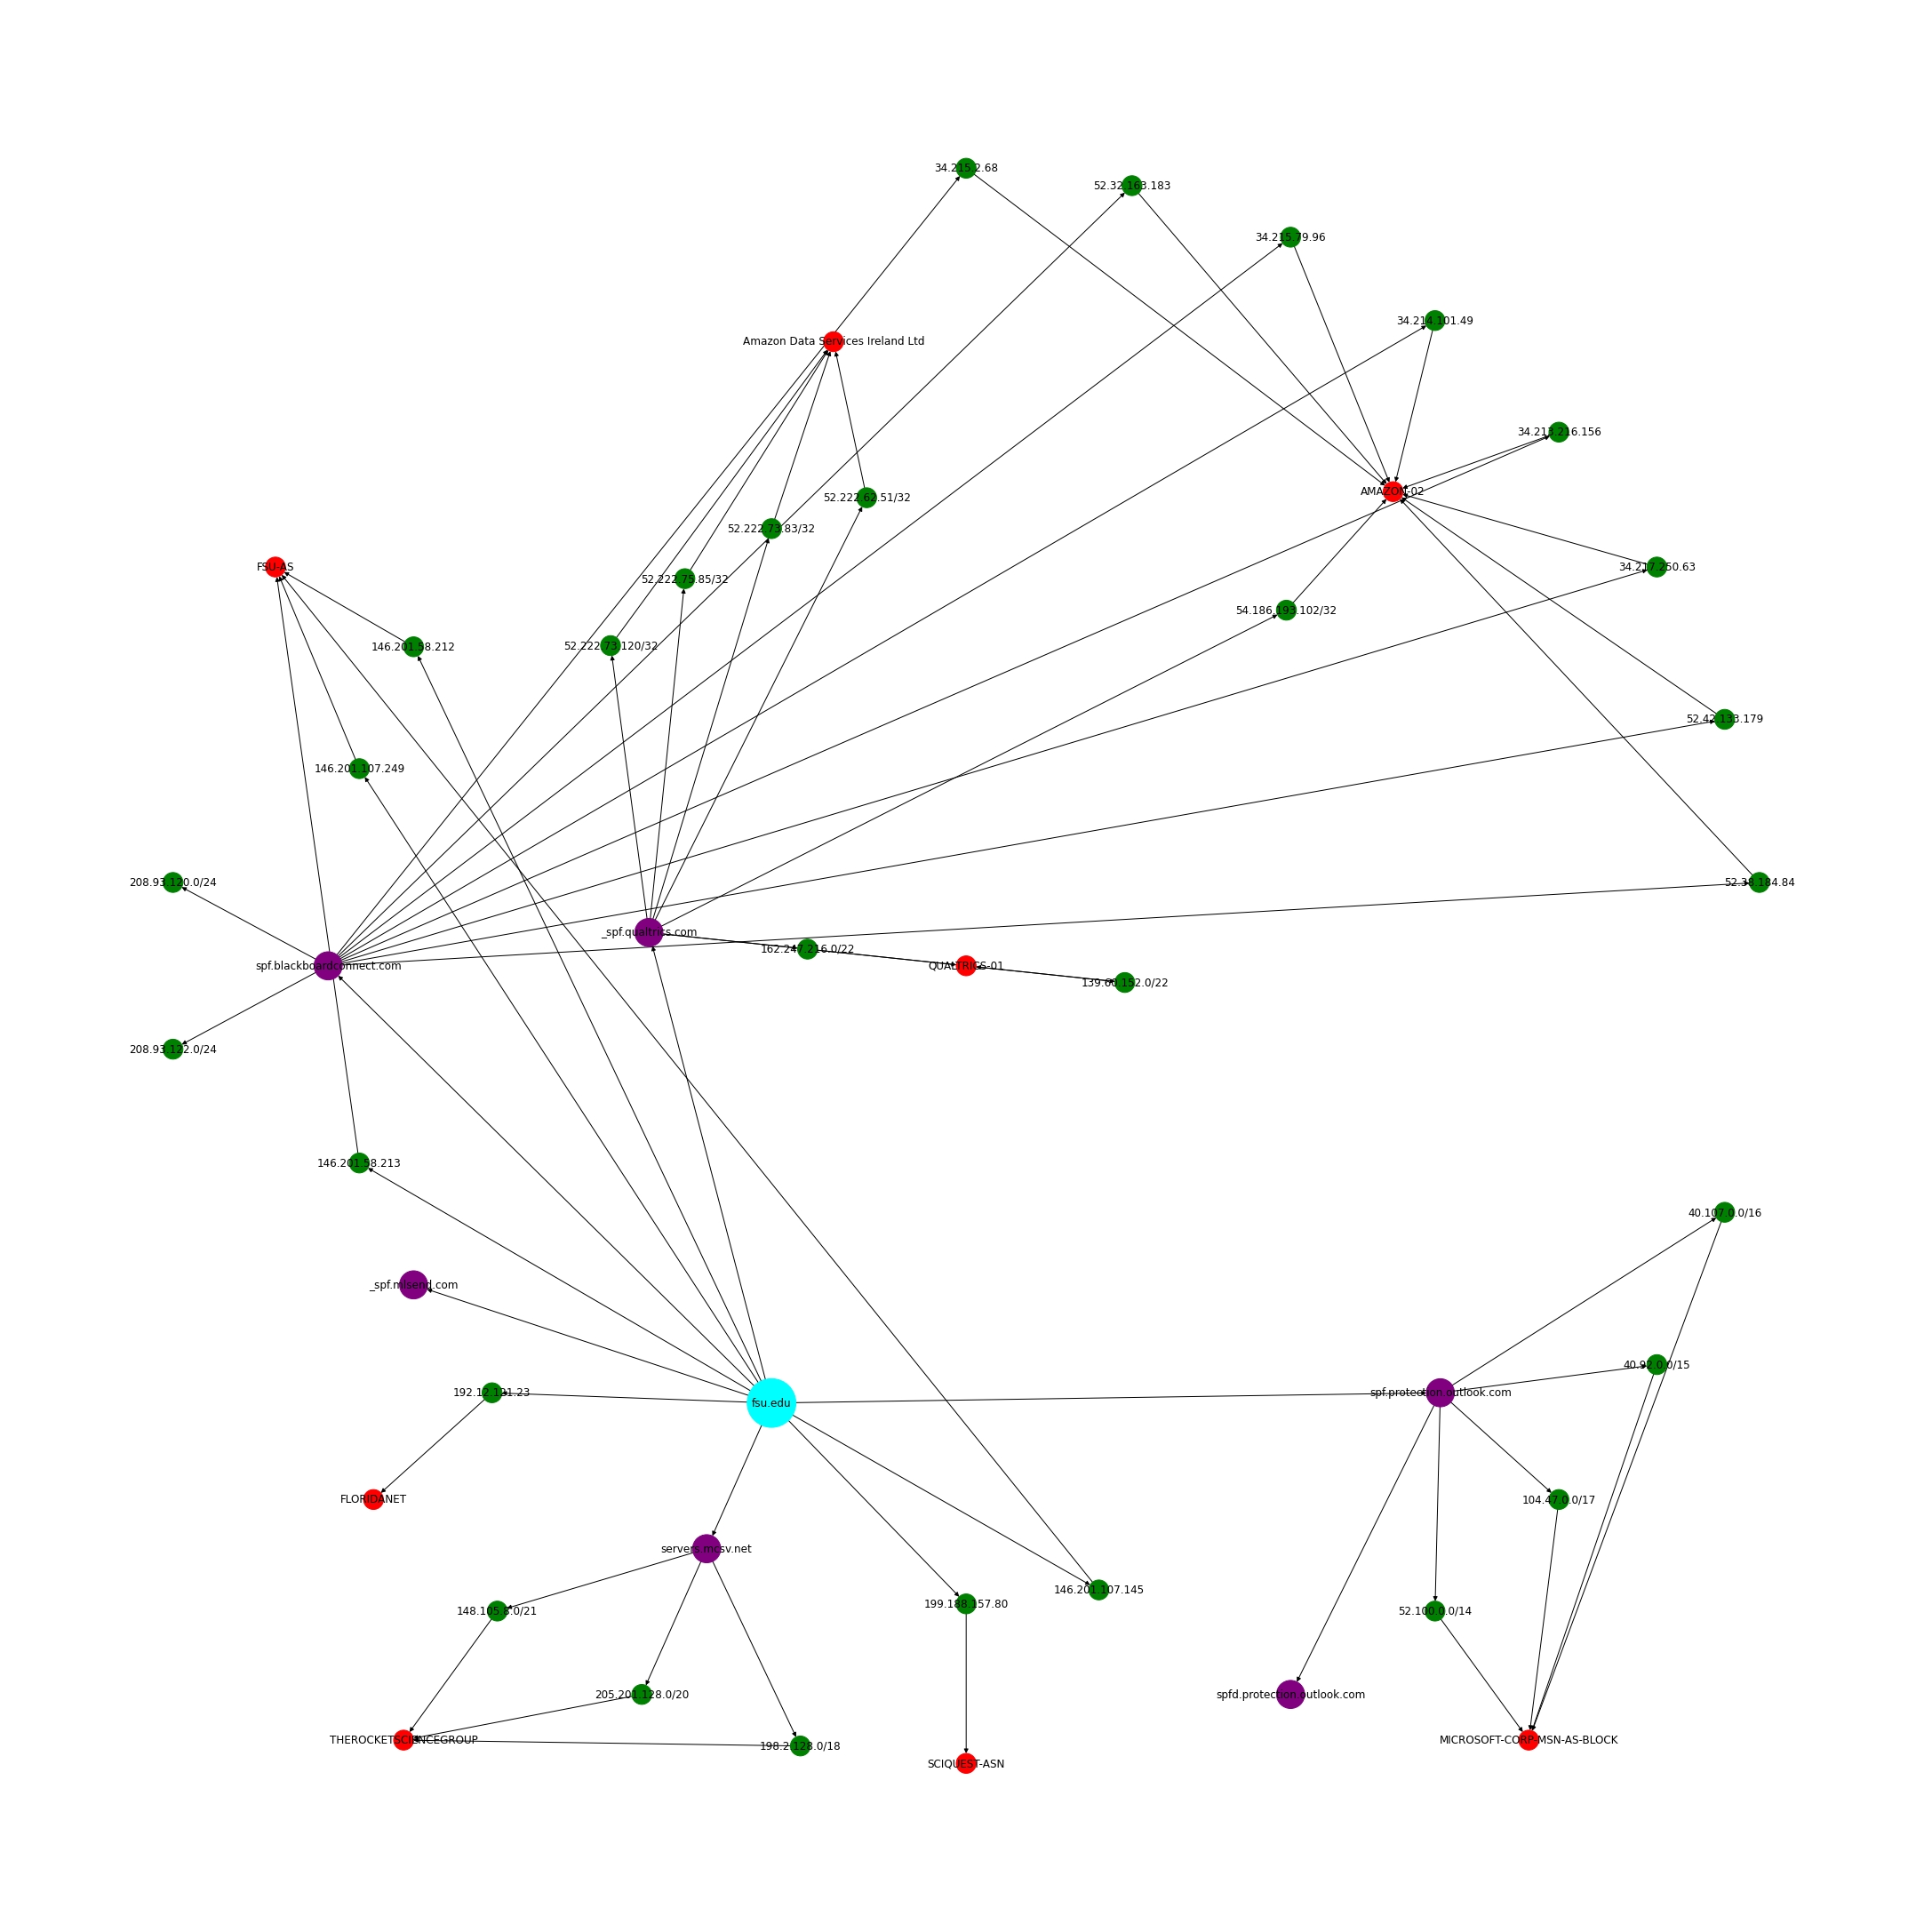

In [54]:
create_network_graph(results_map, ['fsu.edu'], 'images/fsu.edu-networkx.png')

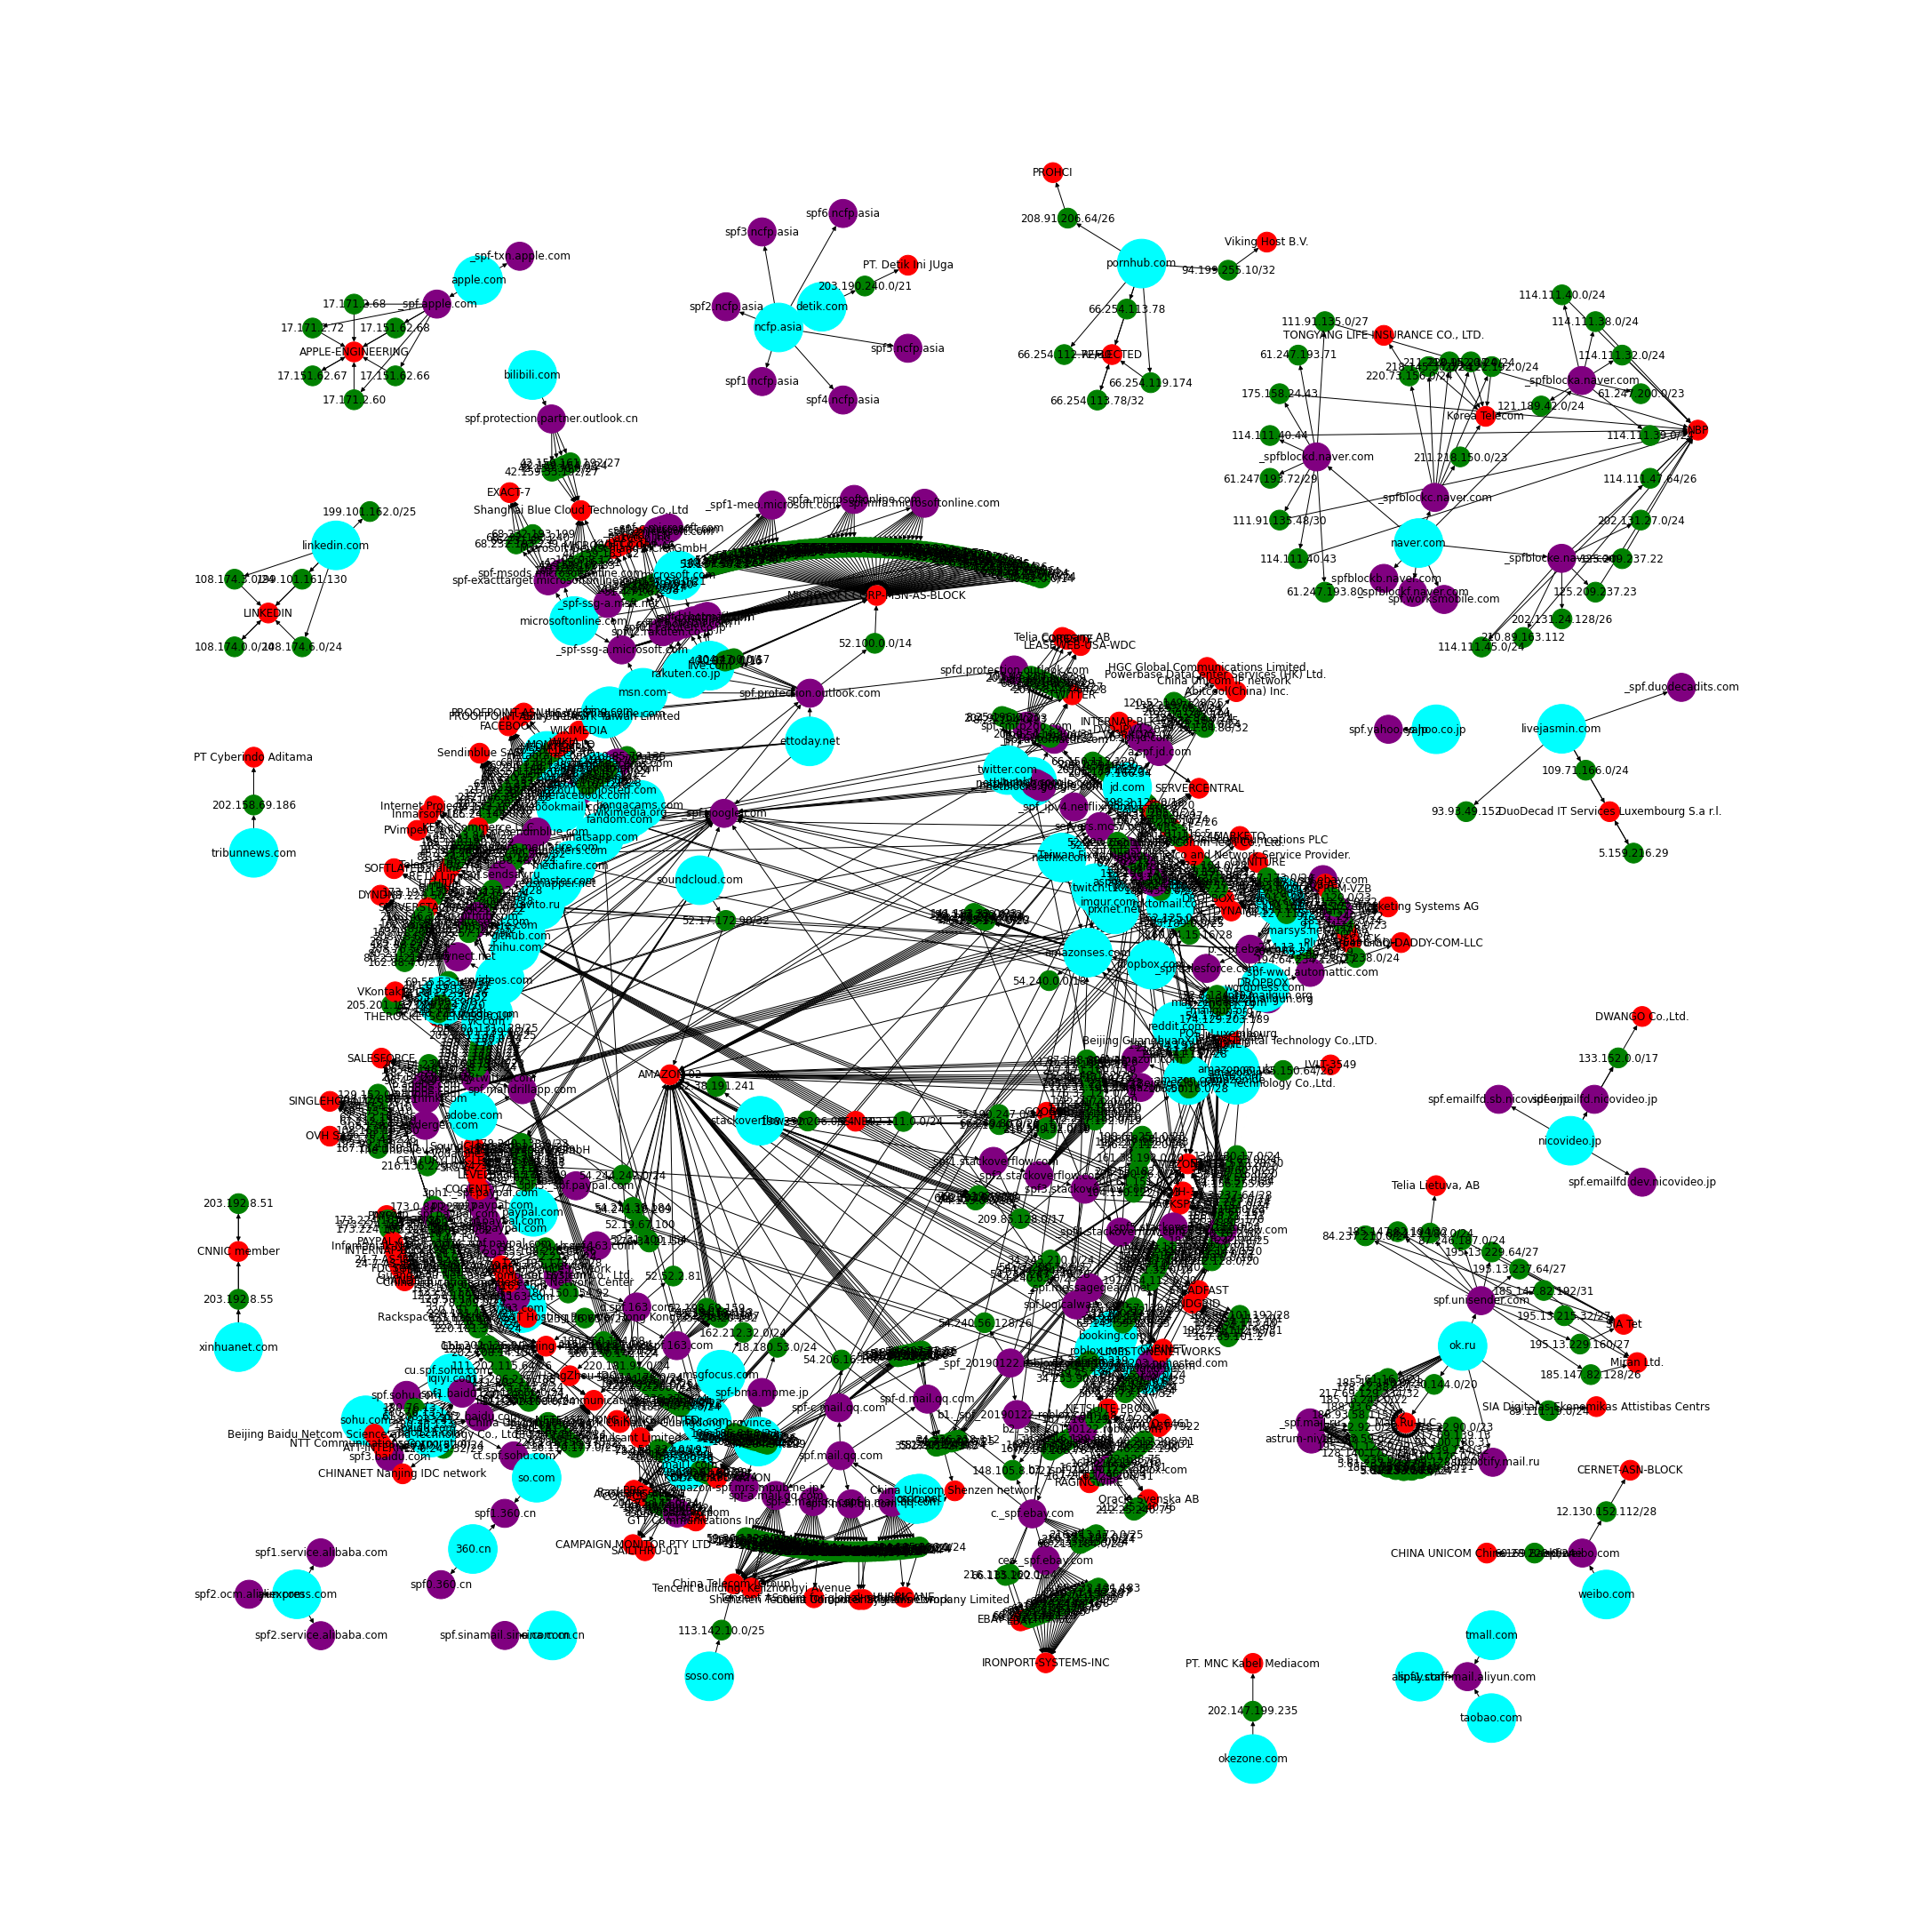

In [55]:
G_alexa_100 = create_network_graph(
    results_map, 
    df[(df.domain_alexa_rank > 0)&(df.domain_alexa_rank <= 100)].domain.unique(),
    'images/alexa-100-networkx.png'
)

In [56]:
print_graph_metrics(G_alexa_100, 'Alexa Top 100', )

### degree_centrality of Alexa Top 100

item     score
0  MICROSOFT-CORP-MSN-AS-BLOCK  0.058771
1                    AMAZON-02  0.048085
2                   AMAZON-AES  0.027605
3        China Telecom (Group)  0.024043
4              _spf.google.com  0.023152
5                  Mail.Ru LLC  0.023152
6                       GOOGLE  0.018700
7                NETSUITE-PROD  0.016028
8            ces._spf.ebay.com  0.015138
9        THEROCKETSCIENCEGROUP  0.014248

### edge_betweenness_centrality of Alexa Top 100

item     score
0  (_spf2.stackoverflow.com, _spf3.stackoverflow....  0.000128
1  (_spf3.stackoverflow.com, _spf4.stackoverflow....  0.000124
2  (_spf4.stackoverflow.com, _spf5.stackoverflow....  0.000104
3  (_spf1.stackoverflow.com, _spf2.stackoverflow....  0.000102
4                      (amazon.com, spf1.amazon.com)  0.000063
5                          (qq.com, spf.mail.qq.com)  0.000063
6                        (csdn.net, spf.mail.qq.com)  0.000063
7  (_spf5.stackoverflow.com, _spf6.stackoverflow....  0.000062
8       (stackoverflow.com, _spf1.stackoverflow.com)  0.000054
9  (_spf_20190122.roblox.com, b1._spf_20190122.ro...  0.000051

### pagerank of Alexa Top 100

item     score
0            MICROSOFT-CORP-MSN-AS-BLOCK  0.032367
1                              AMAZON-02  0.027488
2                             AMAZON-AES  0.014977
3                  China Telecom (Group)  0.013405
4                            Mail.Ru LLC  0.012873
5                                 GOOGLE  0.010316
6  China Unicom Beijing Province Network  0.008977
7                  THEROCKETSCIENCEGROUP  0.008888
8                          NETSUITE-PROD  0.008796
9                              RACKSPACE  0.007827

### closeness_centrality of Alexa Top 100

item     score
0            MICROSOFT-CORP-MSN-AS-BLOCK  0.056605
1                              AMAZON-02  0.047686
2                             AMAZON-AES  0.027676
3                            Mail.Ru LLC  0.023571
4                  China Telecom (Group)  0.023001
5                        _spf.google.com  0.020757
6                                 GOOGLE  0.018997
7                          NETSUITE-PROD  0.016243
8  China Unicom Beijing Province Network  0.015121
9                  THEROCKETSCIENCEGROUP  0.015104

### triangles of Alexa Top 100

item  score
0            133.152.0.0/17      1
1              nicovideo.jp      1
2  spf.emailfd.nicovideo.jp      1
3                   bbc.com      1
4            redsnapper.net      1
5           89.202.185.0/24      1
6                  live.com      0
7         spf-b.hotmail.com      0
8         spf-c.hotmail.com      0
9         spf-a.hotmail.com      0

metric       value
0             num connected components   17.000000
1     min size of connected components    2.000000
2     max size of connected components  962.000000
3     avg size of connected components   66.117647
4  median size of connected components    6.000000

### Longest Path of Alexa Top 100

nodes in path
0        stackoverflow.com
1  _spf1.stackoverflow.com
2  _spf2.stackoverflow.com
3  _spf3.stackoverflow.com
4  _spf4.stackoverflow.com
5  _spf5.stackoverflow.com
6  _spf6.stackoverflow.com
7         205.201.128.0/20
8    THEROCKETSCIENCEGROUP

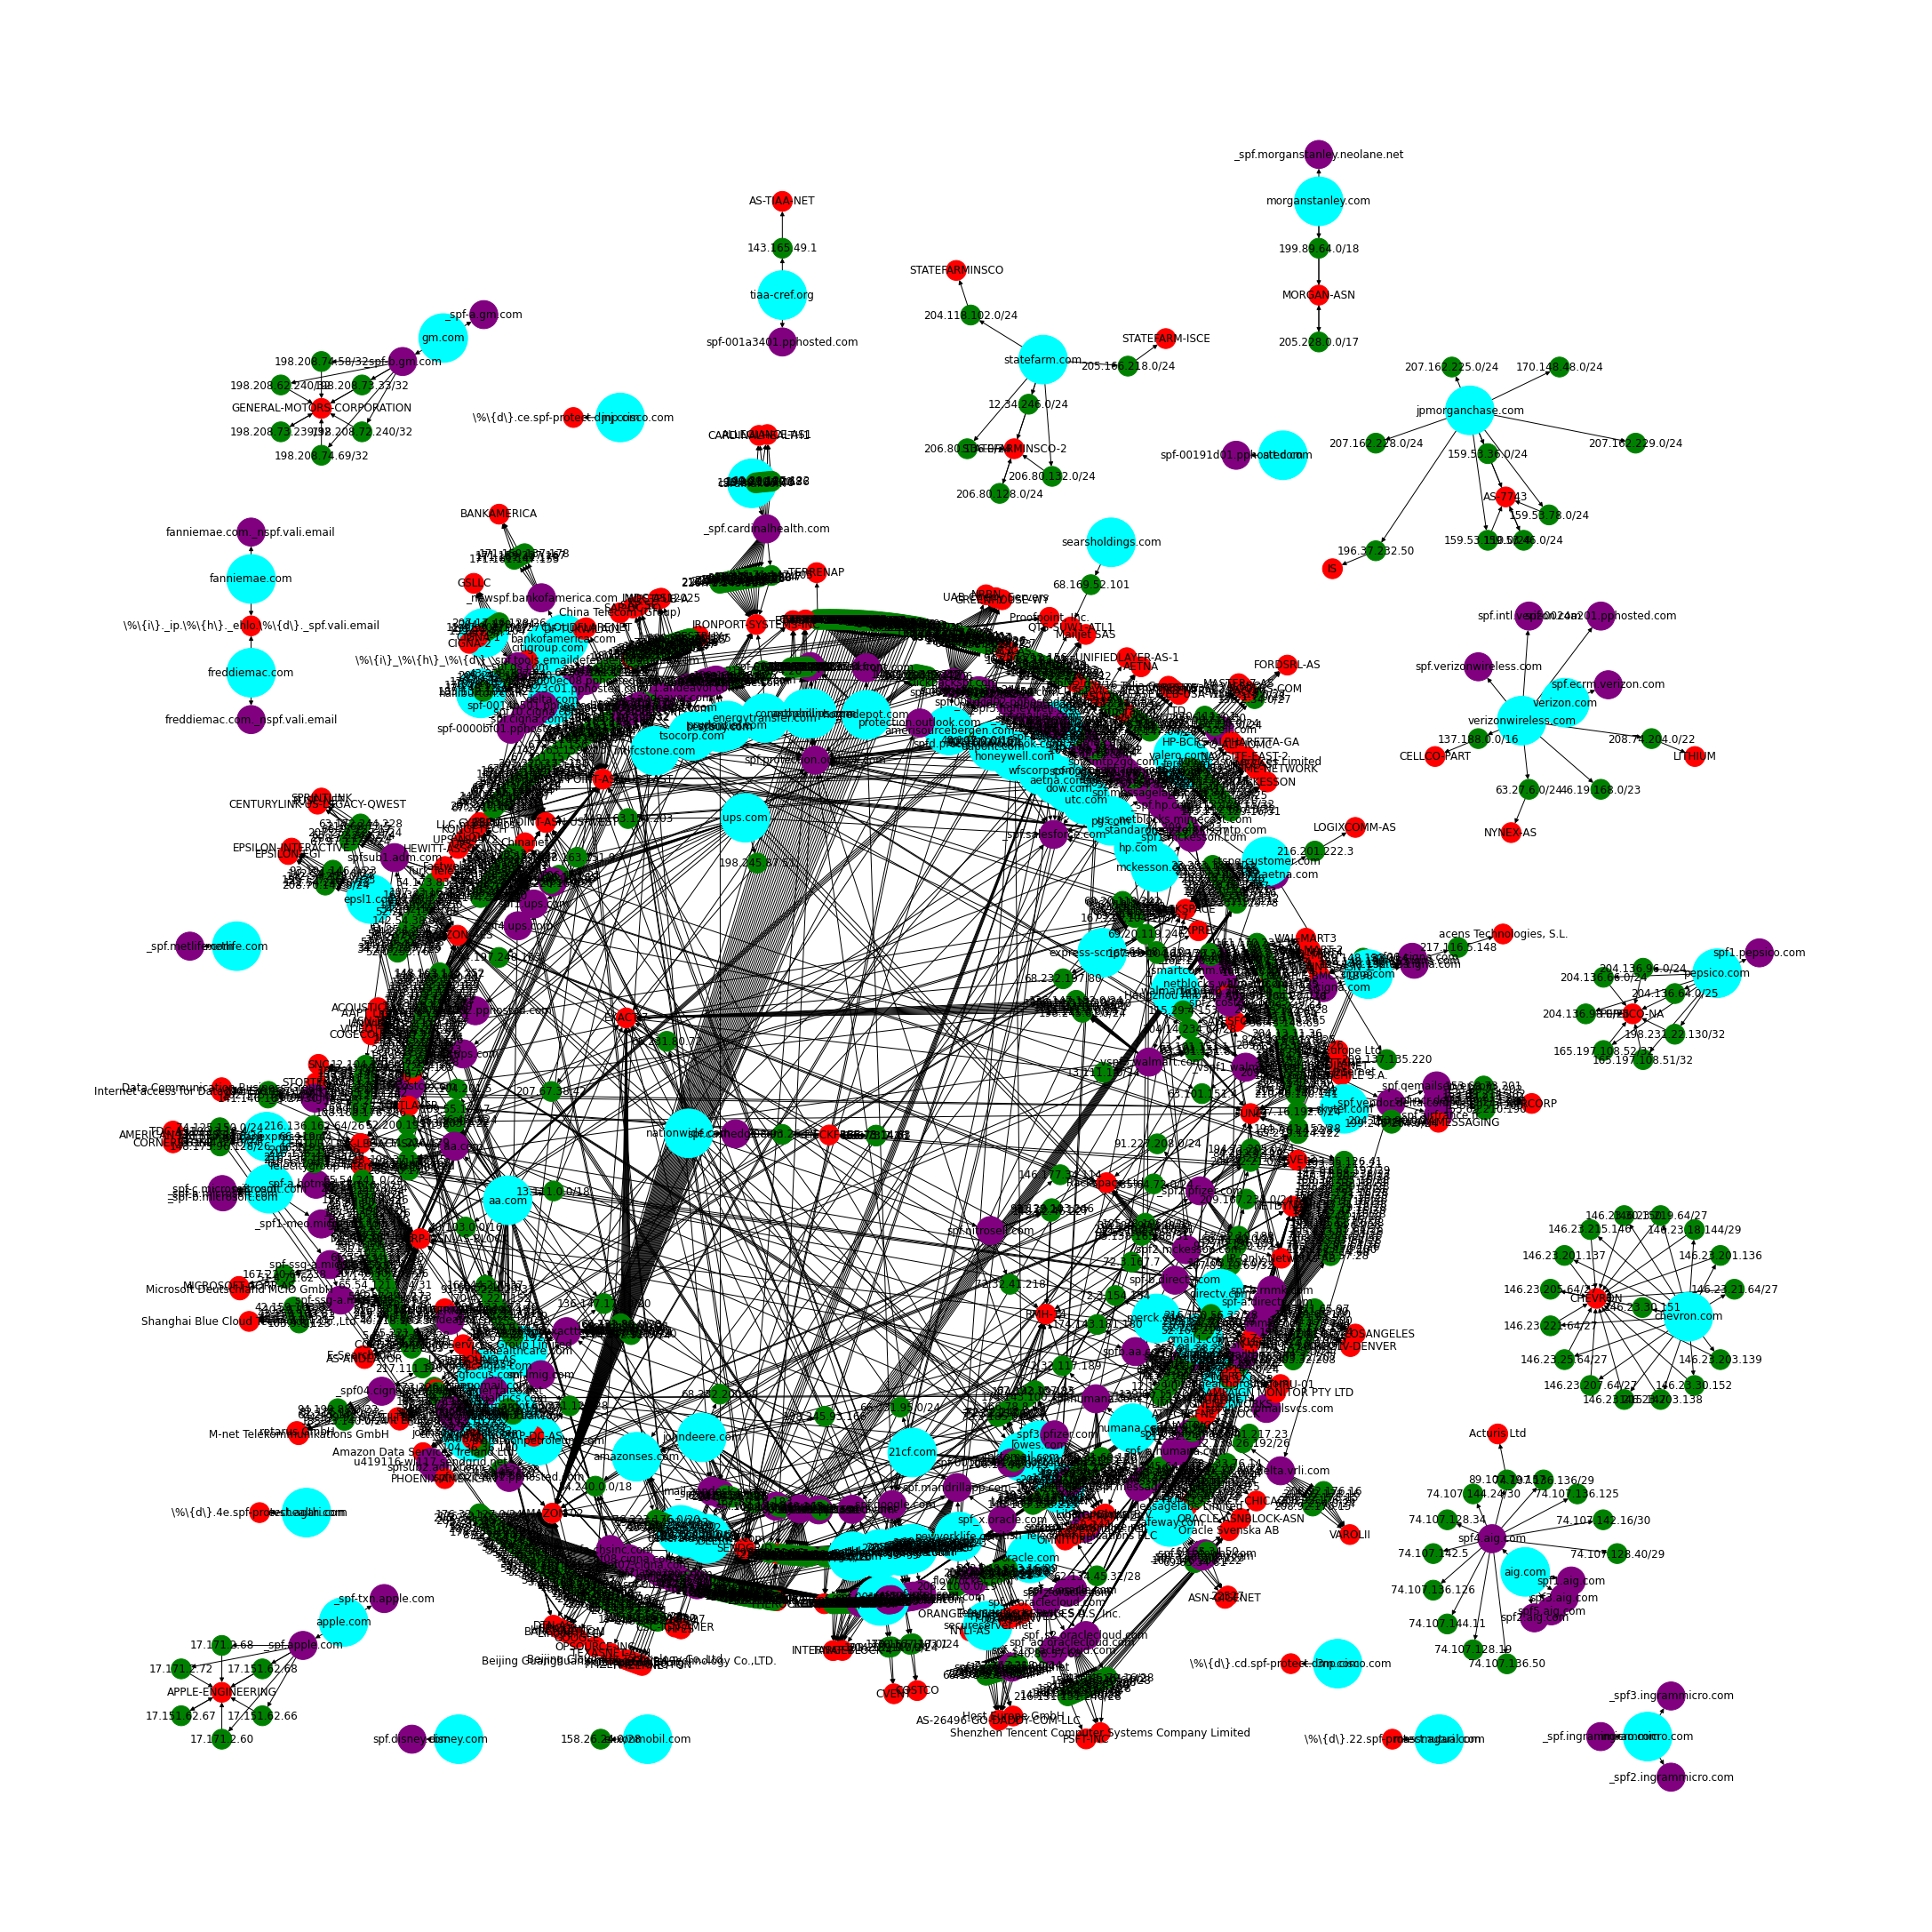

In [57]:
G_fortune_100 = create_network_graph(results_map, f100, 'images/fortune-100-networkx.png')

In [58]:
print_graph_metrics(G_fortune_100, 'Fortune 100')

### degree_centrality of Fortune 100

item     score
0                    AMAZON-02  0.053383
1  MICROSOFT-CORP-MSN-AS-BLOCK  0.036002
2                  NETDYNAMICS  0.030416
3       PROOFPOINT-ASN-US-WEST  0.023588
4       PROOFPOINT-ASN-US-EAST  0.022346
5            spf.workfront.com  0.022346
6                   AMAZON-AES  0.021726
7                    RACKSPACE  0.021105
8                     SENDGRID  0.018622
9                      EXACT-7  0.018001

### edge_betweenness_centrality of Fortune 100

item     score
0                 (spf.aa.com, spfb.aa.com)  0.000023
1                   (ups.com, spf1.ups.com)  0.000020
2       (oracle.com, spf_c.oraclecloud.com)  0.000018
3        (delta.com, _spf.vendor.delta.com)  0.000017
4                      (aa.com, spf.aa.com)  0.000016
5         (libertymutual.com, spf.lmig.com)  0.000015
6        (homedepot.com, spf.workfront.com)  0.000015
7  (spf.lmig.com, cust-spf.exacttarget.com)  0.000015
8              (spf1.ups.com, mktomail.com)  0.000014
9             (cigna.com, _spf09.cigna.com)  0.000014

### pagerank of Fortune 100

item     score
0                    AMAZON-02  0.028516
1  MICROSOFT-CORP-MSN-AS-BLOCK  0.020302
2                  NETDYNAMICS  0.016538
3       PROOFPOINT-ASN-US-WEST  0.014062
4       PROOFPOINT-ASN-US-EAST  0.013397
5                   AMAZON-AES  0.011886
6                    RACKSPACE  0.011379
7                     SENDGRID  0.010126
8                      EXACT-7  0.009764
9         IRONPORT-SYSTEMS-INC  0.006864

### closeness_centrality of Fortune 100

item     score
0                    AMAZON-02  0.050234
1  MICROSOFT-CORP-MSN-AS-BLOCK  0.035386
2                  NETDYNAMICS  0.030045
3       PROOFPOINT-ASN-US-WEST  0.026594
4       PROOFPOINT-ASN-US-EAST  0.025560
5                   AMAZON-AES  0.023487
6                    RACKSPACE  0.021600
7                     SENDGRID  0.019895
8                      EXACT-7  0.017991
9   spf.protection.outlook.com  0.013062

### triangles of Fortune 100

item  score
0  nets1.spf.messagelabs.com      6
1                 humana.com      6
2                     aa.com      2
3                 spf.aa.com      2
4            85.158.136.0/21      1
5           193.109.254.0/23      1
6           194.106.220.0/23      1
7           195.245.230.0/23      1
8             46.226.48.0/21      1
9            95.131.104.0/21      1

metric        value
0             num connected components    21.000000
1     min size of connected components     2.000000
2     max size of connected components  1476.000000
3     avg size of connected components    76.761905
4  median size of connected components     5.000000

### Longest Path of Fortune 100

nodes in path
0            aa.com
1        spf.aa.com
2       spfb.aa.com
3     amazonses.com
4  199.255.192.0/22
5         AMAZON-02

In [59]:
def create_heatmap(df, cidrs_filename, image_file, title):
    all_cidrs = set()
    num_ips = 0
    for cidrs in df.ips.values:
        for cidr in cidrs:
           all_cidrs.add(cidr)

    with open(cidrs_filename, 'w') as outf:
        for cidr in all_cidrs:
            try:
                netw = netaddr.IPNetwork(cidr)
                if not netw.is_reserved() and not netw.is_private() and not netw.is_link_local():
                    print('\t'.join([str(netw), '0xFF0000', '70']), file=outf)
                    num_ips += netw.size
            except KeyboardInterrupt:
                break
            except Exception as e:
                #print(e, 'on', cidr)
                pass
    os.system(f'cat /dev/null | ipv4-heatmap -a data/iana-labels.txt -o {image_file} -s {cidrs_filename}')
    display(Markdown(f'### {title}'))
    print(f'{len(all_cidrs):,.0f} CIDRS (representing {num_ips:,.0f} IPs)')
    display(HTML(f'<img src="{image_file}" width="600px">'))

In [60]:
create_heatmap(
    df[(df.domain.isin(f1000))],
    'scratch/cidrs-for-heatmap-fortune-1000.txt',
    'images/fortune-1000-heatmap.png',
    'Fortune 1,000 SPF Trusted Networks'
)

### Fortune 1,000 SPF Trusted Networks

7,337 CIDRS (representing 6,795,827 IPs)


In [61]:
create_heatmap(
    df[(df.domain_alexa_rank > 0)&(df.domain_alexa_rank <= 1000)],
    'scratch/cidrs-for-heatmap-alexa-1000.txt',
    'images/alexa-1000-heatmap.png',
    'Alexa 1,000 SPF Trusted Networks'
)

### Alexa 1,000 SPF Trusted Networks

4,448 CIDRS (representing 22,341,952 IPs)


In [62]:
create_heatmap(
    df[(df.domain_alexa_rank > 0)&(df.domain_alexa_rank <= 10000)],
    'scratch/cidrs-for-heatmap-alexa-10000.txt',
    'images/alexa-10000-heatmap.png',
    'Alexa 10,000 SPF Trusted Networks'
)

### Alexa 10,000 SPF Trusted Networks

22,582 CIDRS (representing 32,540,642 IPs)


In [63]:
create_heatmap(
    df[(df.domain_alexa_rank > 0)&(df.domain_alexa_rank <= 100000)],
    'scratch/cidrs-for-heatmap-alexa-100000.txt',
    'images/alexa-100000-heatmap.png',
    'Alexa 100,000 SPF Trusted Networks'
)

### Alexa 100,000 SPF Trusted Networks

103,441 CIDRS (representing 2,426,231,239 IPs)


In [64]:
create_heatmap(
    df[(df.domain_alexa_rank > 0)&(df.domain_alexa_rank <= 1000000)],
    'scratch/cidrs-for-heatmap-alexa-1000000.txt',
    'images/alexa-1000000-heatmap.png',
    'Alexa 1,000,000 SPF Trusted Networks'
)

### Alexa 1,000,000 SPF Trusted Networks

324,066 CIDRS (representing 18,813,088,820 IPs)


In [65]:
# Number of IPs in a /7 = 33,554,432
slice_df = alexa_ranked_df[alexa_ranked_df.largest_public_network_size >= 33554432][['domain_alexa_rank', 'domain', 'largest_public_network']].copy()
slice_df['largest_public_network'] = slice_df.largest_public_network.map(lambda n: str(n))
slice_df['domain_alexa_rank'] = slice_df.domain_alexa_rank.map(lambda n: int(n))
display(Markdown('### Alexa Top 1M Domains Trusting slash-7 or bigger'))
slice_df.sort_values('domain_alexa_rank').to_csv('results/Alexa Top 1M Domains Trusting slash-7 or bigger.csv', index=False)

### Alexa Top 1M Domains Trusting slash-7 or bigger

In [66]:
display(Markdown('### Counts of domains and their largest trusted CIDRs'))
pd.pivot_table(
    alexa_ranked_df[['domain', 'largest_public_network_size']].drop_duplicates(),
    index='largest_public_network_size',
    aggfunc='count'
).sort_values('largest_public_network_size')

### Counts of domains and their largest trusted CIDRs

domain
largest_public_network_size        
0                             44411
1                             86246
2                               215
4                               232
8                               899
16                             2638
32                             2905
64                             1260
128                            1723
256                           16949
512                            5346
1024                          14190
2048                           4755
4096                           3349
8192                           1721
16384                         26006
32768                           395
65536                         13725
131072                          117
262144                        46172
524288                           14
1048576                           6
2097152                           2
4194304                           5
8388608                           3
16777216                         26
33554432                          1
67108864                          1
134217728                         2
268435456                         4
536870912                         3
1073741824                        5
2147483648                        1
4294967296                        4

In [67]:
with pd.option_context('display.max_rows', 100, 'display.max_colwidth', 100):
    slice_df = f100_df[['domain', 'email_security_providers', 'includes']].copy()
    slice_df['includes'] = slice_df.includes.map(lambda includes: ','.join(includes) if includes else '-')
    slice_df['email_security_providers'] = slice_df.email_security_providers.map(lambda esp: ','.join(esp) if esp else '-')
    slice_df = slice_df.sort_values('email_security_providers')
    slice_df.to_csv('results/Fortune 100 Email Security Providers Listing (via SPF).csv', index=False)
    display(Markdown('### Fortune 100 Email Security Providers Listing (via SPF)'))
    display(slice_df)

### Fortune 100 Email Security Providers Listing (via SPF)

domain     email_security_providers  \
2959         hcahealthcare.com                            -   
1350658      morganstanley.com                            -   
1386392          cvshealth.com                            -   
1623203            directv.com                            -   
1654198         exxonmobil.com                            -   
1781964            pepsico.com                            -   
1922043                 aa.com                            -   
2064716          fanniemae.com                            -   
2168001            verizon.com                            -   
2193392            tsocorp.com                            -   
2263574            bestbuy.com                            -   
2354637                aig.com                            -   
2381156          statefarm.com                            -   
1266443  unitedhealthgroup.com                            -   
2525361                 gm.com                            -   
2562602         massmutual.com                            -   
2642401             disney.com                            -   
2643194         nationwide.com                            -   
2680128          microsoft.com                            -   
2696731             google.com                            -   
2772918              lowes.com                            -   
2881096             amazon.com                            -   
3058968     conocophillips.com                            -   
3122050              intel.com                            -   
3141745             oracle.com                            -   
3222479         freddiemac.com                            -   
3243969        newyorklife.com                            -   
2541208      jpmorganchase.com                            -   
1251223    americanexpress.com                            -   
1783825            wfscorp.com                            -   
813598       searsholdings.com                            -   
267546                 jnj.com                            -   
431321         ingrammicro.com                            -   
542067              target.com                            -   
216909                 dow.com                            -   
168058          prudential.com                            -   
597464                  3m.com                            -   
619466               merck.com                            -   
701415           honeywell.com                            -   
296600     johnsoncontrols.com                            -   
163766             walmart.com                            -   
299264             metlife.com                            -   
987070     express-scripts.com                            -   
1009257            chevron.com                            -   
90398        libertymutual.com                            -   
147089               apple.com                            -   
909768                 adm.com                            -   
1060405     energytransfer.com               Cisco Ironport   
1061709           cardinal.com               Cisco Ironport   
934260               aetna.com                     Mimecast   
3154343                 hp.com                     Mimecast   
77896          intlfcstone.com          Mimecast,Proofpoint   
3201723             costco.com                   Proofpoint   
3008179          johndeere.com                   Proofpoint   
2726215          homedepot.com                   Proofpoint   
96891                   gs.com                   Proofpoint   
222921               sysco.com                   Proofpoint   
2686068                ups.com                   Proofpoint   
3070528    generaldynamics.com                   Proofpoint   
2932822                ibm.com                   Proofpoint   
3103890  amerisourcebergen.com                   Proofpoint   
3303077               21cf.com                   Proofpoint   
306503            mckesson.com                   Proofp

In [68]:
pvt = pd.pivot_table(
    all_registered_domains_df[['num_email_security_providers', 'domain']].drop_duplicates(),
    index='num_email_security_providers',
    aggfunc='count'
).reset_index()
pvt.to_csv('results/Number of Email Security Providers (via SPF).csv', index=False)
display(Markdown('### Number of Email Security Providers (via SPF)'))
display(pvt)

### Number of Email Security Providers (via SPF)

num_email_security_providers   domain
0                             0  3069785
1                             1   190112
2                             2    11393
3                             3      468
4                             4       35
5                             5        1

In [69]:
cols = ['domain_alexa_rank', 'domain', 'num_email_security_providers', 'email_security_providers']
slice_df = all_registered_domains_df[all_registered_domains_df.num_email_security_providers >= 4][cols]
slice_df['email_security_providers'] = slice_df.email_security_providers.map(lambda esp: ','.join(esp) if esp else '-')
slice_df['domain_alexa_rank'] = slice_df.domain_alexa_rank.map(lambda rank: rank if rank != -1 else '-')
slice_df = slice_df.sort_values('num_email_security_providers')
slice_df.to_csv('results/Domains with 4 or more Email Security Providers (via SPF).csv', index=False)
display(Markdown('### Domains with 4 or more Email Security Providers (via SPF)'))
display(slice_df)

### Domains with 4 or more Email Security Providers (via SPF)

domain_alexa_rank                       domain  \
93802                   -              mqsadvisors.com   
1731181                 -                 primo.com.au   
1827477                 -                   fera.co.uk   
2102952            110703                   pivotal.io   
2149043                 -                premiercu.org   
2248010                 -           pendletonplace.org   
2313274                 -              mysolutions.biz   
1662509                 -           tracintermodal.com   
2382273            220653           pallet-track.co.uk   
2498208                 -            castle-forbes.com   
2755670                 -               uspotatoes.com   
2901663            105638                  hbtbank.com   
2943359            302625              cnbsomerset.com   
2962779              3738                    spring.io   
3037624                 -        pumpmanpittsburgh.com   
2389621                 -       primosmallgoods.com.au   
1472140            517156          springframework.org   
1425639                 -                  hans.com.au   
1404660                 -      surfaceprocessing.co.uk   
227054                  -          reynoldsgroup.co.uk   
300562                  -                    nbg.co.uk   
335975                  -            readonarizona.org   
356351                  -           elizabetharden.com   
450302                  -                     s3vc.com   
556257                  -          jumpdesigngroup.com   
3091546                 -          winslowtownship.com   
780549                  -                zeitereye.com   
968133                  -             ensolsystems.com   
1000656                 -          mesadesigngroup.com   
1117371                 -              jbsswift.com.au   
1215140                 -  theforgeentertainment.co.uk   
1317681                 -               pipertrust.org   
1383687                 -            fluidicenergy.com   
965801                  -            usplabsdirect.com   
3231729                 -              pagnatokarp.com   
678153                  -                 atg-it.co.uk   

         num_email_security_providers  \
93802                               4   
1731181                             4   
1827477                             4   
2102952                             4   
2149043                             4   
2248010                             4   
2313274                             4   
1662509                             4   
2382273                             4   
2498208                             4   
2755670                             4   
2901663                             4   
2943359                             4   
2962779                             4   
3037624                             4   
2389621                             4   
1472140                             4   
1425639                             4   
1404660                             4   
227054                              4   
300562                              4   
335975                              4   
356351                              4   
450302                              4   
556257                              4   
3091546                             4   
780549                              4   
968133                              4   
1000656                             4   
1117371                             4   
1215140                             4   
1317681                             4   
1383687                             4   
965801                              4   
3231729                             4   
678153                              5   

                                  email_security_providers  
93802                 ZixMail,Protonmail,fusemail,AppRiver  
1731181                Mimecast,Symantec,Mcafee,Proofpoint  
1827477            Symantec,Protonmail,Forcepoint,fusemail  
2102952        Mimecast,Cisco Ironport,Proofpoint,Symantec  
2149043        Mimecast,Fortinet,Cisco

### Amount of AWS IP Space Trusted (All domains)

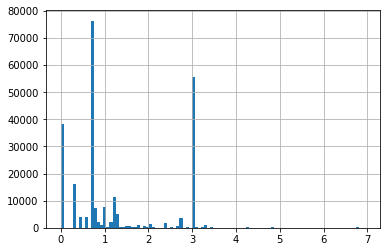

In [70]:
display(Markdown('### Amount of AWS IP Space Trusted (All domains)'))
display(all_registered_domains_df[all_registered_domains_df.aws_networks_size > 0].aws_networks_size.map(lambda s: math.log(s, 10)).hist(bins=100))

### Amount of Azure IP Space Trusted (All domains)

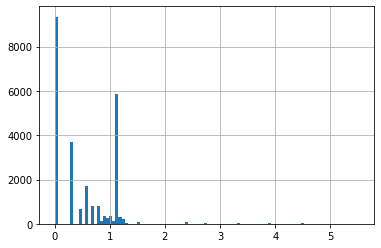

In [71]:
display(Markdown('### Amount of Azure IP Space Trusted (All domains)'))
display(all_registered_domains_df[all_registered_domains_df.azure_networks_size > 0].azure_networks_size.map(lambda s: math.log(s, 10)).hist(bins=100))

### Amount of GCP IP Space Trusted (All domains)

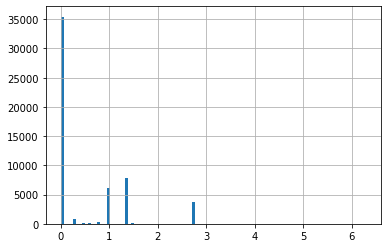

In [72]:
display(Markdown('### Amount of GCP IP Space Trusted (All domains)'))
display(all_registered_domains_df[all_registered_domains_df.gcp_networks_size > 0].gcp_networks_size.map(lambda s: math.log(s, 10)).hist(bins=100))

### Amount of AWS IP Space Trusted (Fortune 1000)

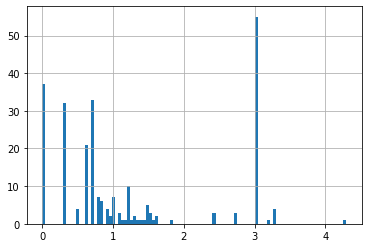

In [73]:
display(Markdown('### Amount of AWS IP Space Trusted (Fortune 1000)'))
display(f1000_df[f1000_df.aws_networks_size > 0].aws_networks_size.map(lambda s: math.log(s, 10)).hist(bins=100))

### Amount of Azure IP Space Trusted (Fortune 1000)

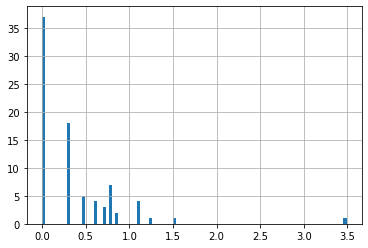

In [74]:
display(Markdown('### Amount of Azure IP Space Trusted (Fortune 1000)'))
display(f1000_df[f1000_df.azure_networks_size > 0].azure_networks_size.map(lambda s: math.log(s, 10)).hist(bins=100))

### Amount of GCP IP Space Trusted (Fortune 1000)

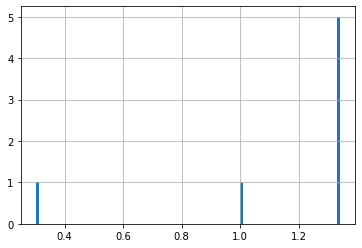

In [75]:
display(Markdown('### Amount of GCP IP Space Trusted (Fortune 1000)'))
display(f1000_df[f1000_df.gcp_networks_size > 0].gcp_networks_size.map(lambda s: math.log(s, 10)).hist(bins=100))

In [123]:
slice_df = df[(df.aws_networks_size > 0)|(df.azure_networks_size > 0)|(df.gcp_networks_size > 0)].copy()

In [149]:
trie = PatriciaTrie()

gcp_ranges = requests.get('http://www.gstatic.com/ipranges/cloud.json').json()
for rec in gcp_ranges['prefixes']:
    if 'ipv4Prefix' in rec:
        trie.insert(rec['ipv4Prefix'], '{} ({})'.format(rec['service'], rec['scope']))

aws_ranges = requests.get('https://ip-ranges.amazonaws.com/ip-ranges.json').json()
for rec in aws_ranges['prefixes']:
    if 'ip_prefix' in rec:
        trie.insert(rec['ip_prefix'], '{} ({})'.format(rec['service'], rec['region']))

# https://www.microsoft.com/en-us/download/confirmation.aspx?id=56519
azure_ranges = json.load(open('data/ServiceTags_Public_20200601.json'))
azure_ranges = [(rec['properties']['addressPrefixes'], '{} {}'.format(rec['properties']['platform'], rec['properties']['systemService'])) for rec in azure_ranges['values']]
azure_ranges = [(ip, note) for ips, note in azure_ranges for ip in ips]
for ip, note in azure_ranges:
    trie.insert(ip, note)

def search_cloud_ranges(networks):
    results = set()
    for network in networks:
        try:
            for label in trie.find_all(network):
                results.add(label[1])
        except:
            pass
    return list(results)

slice_df['aws_network_labels'] = slice_df.aws_networks.map(search_cloud_ranges)
slice_df['azure_network_labels'] = slice_df.azure_networks.map(search_cloud_ranges)
slice_df['gcp_network_labels'] = slice_df.gcp_networks.map(search_cloud_ranges)

In [201]:
def display_and_save_csv(df, title):
    display(Markdown(f'### {title}'))
    df.to_csv(f'results/{title}.csv', index=False)
    display(df)

In [202]:
display_and_save_csv(
    slice_df[(slice_df.azure_networks_size >10)&(slice_df.domain_alexa_rank != -1.0)]\
    [['domain', 'azure_networks_size', 'azure_network_labels', 'domain_alexa_rank']].\
    sort_values('azure_networks_size', ascending=False),
    'Alexa top1m domains trusting Azure Networks'
)

### Alexa top1m domains trusting Azure Networks

domain  azure_networks_size azure_network_labels  \
1547210                  pico.com               327680                   []   
546033          globalenglish.com                65536                   []   
2951076                 asprs.org                65536                   []   
53615                 palador.com                65536             [Azure ]   
941501         companycasuals.com                32772             [Azure ]   
...                           ...                  ...                  ...   
617198                sanicare.de                   11             [Azure ]   
2565411               tjmedia.com                   11                   []   
2956134             camparino.com                   11             [Azure ]   
2294951  mitsubishielectric.co.jp                   11             [Azure ]   
2563701              planvital.cl                   11             [Azure ]   

         domain_alexa_rank  
1547210           846370.0  
546033            162102.0  
2951076           527470.0  
53615             605307.0  
941501            302877.0  
...                    ...  
617198            338236.0  
2565411           837242.0  
2956134           681979.0  
2294951            30521.0  
2563701           343447.0  

[777 rows x 4 columns]

In [203]:
display_and_save_csv(
    slice_df[(slice_df.aws_networks_size >10)&(slice_df.domain_alexa_rank != -1.0)]\
    [['domain', 'aws_networks_size', 'aws_network_labels', 'domain_alexa_rank']].\
    sort_values('aws_networks_size', ascending=False),
    'Alexa top1m domains trusting AWS Networks'
)

### Alexa top1m domains trusting AWS Networks

domain  aws_networks_size  \
1785013   eleconomista.com.mx             524481   
2240828       elempresario.mx             524480   
1037263           dynamic.ooo             197638   
2706790            kfc.com.sg             148487   
1895938  hawaii-arukikata.com             132096   
...                       ...                ...   
1104648            disher.com                 11   
129940           makeup.co.nz                 11   
2192863            nijobs.com                 11   
2919149            tokai.coop                 11   
2134402           quit.org.au                 11   

                                        aws_network_labels  domain_alexa_rank  
1785013  [EC2 (us-west-2), EC2 (us-east-1), EC2 (us-wes...            19348.0  
2240828                 [EC2 (us-east-1), EC2 (us-west-1)]           356551.0  
1037263  [AMAZON (us-east-1), EC2 (eu-central-1), EC2 (...           234341.0  
2706790  [EC2 (us-east-1), AMAZON (us-east-1), EC2 (ap-...           292883.0  
1895938         [EC2 (ap-northeast-1), AMAZON (us-east-1)]            41560.0  
...                                                    ...                ...  
1104648  [EC2 (us-east-2), EC2 (ap-northeast-1), EC2 (a...           788380.0  
129940                              [EC2 (ap-southeast-2)]           555853.0  
2192863                               [EC2 (eu-central-1)]           977455.0  
2919149                             [EC2 (ap-northeast-1)]            60858.0  
2134402            [EC2 (us-east-1), EC2 (ap-southeast-2)]           236981.0  

[16062 rows x 4 columns]

In [204]:
display_and_save_csv(
    slice_df[(slice_df.gcp_networks_size >10)&(slice_df.domain_alexa_rank != -1.0)]\
    [['domain', 'gcp_networks_size', 'gcp_network_labels', 'domain_alexa_rank']].\
    sort_values('gcp_networks_size', ascending=False),
    'Alexa top1m domains trusting GCP Networks'
)

### Alexa top1m domains trusting GCP Networks

domain  gcp_networks_size  \
2786642               yext.com            1921536   
1534009           kiwitaxi.com            1899520   
359143   yadayadamarketing.com                722   
2357225         lauradoyle.org                722   
641218          amymyersmd.com                535   
...                        ...                ...   
875352    cidentertainment.com                 17   
1767099         beprepared.com                 13   
2340537   halloweenexpress.com                 12   
2050560             umpqua.com                 11   
2893776      charlottesweb.com                 11   

                                        gcp_network_labels  domain_alexa_rank  
2786642  [Google Cloud (us-east1), Google Cloud (europe...            77965.0  
1534009  [Google Cloud (us-east1), Google Cloud (global...           342429.0  
359143                           [Google Cloud (us-west1)]           614803.0  
2357225                          [Google Cloud (us-west1)]           215697.0  
641218   [Google Cloud (us-east1), Google Cloud (northa...            52695.0  
...                                                    ...                ...  
875352   [Google Cloud (us-east1), Google Cloud (northa...           248634.0  
1767099  [Google Cloud (us-east1), Google Cloud (northa...           269704.0  
2340537                       [Google Cloud (us-central1)]           308774.0  
2050560  [Google Cloud (us-central1), Google Cloud (glo...           326075.0  
2893776  [Google Cloud (us-east1), Google Cloud (us-eas...           105933.0  

[1844 rows x 4 columns]

In [205]:
f1000_slice_df = slice_df[slice_df.domain.isin(f1000)].copy()
a1000_slice_df = slice_df[(slice_df.domain_alexa_rank > 0)&(slice_df.domain_alexa_rank <= 1000)].copy()

In [206]:
display_and_save_csv(
    f1000_slice_df[(f1000_slice_df.azure_networks_size >10)]\
    [['domain', 'azure_networks_size', 'azure_network_labels', 'includes']].\
    sort_values('azure_networks_size', ascending=False),
    'Fortune 1000 Trusting Azure Networks'
)

### Fortune 1000 Trusting Azure Networks

domain  azure_networks_size  \
1147044         edgewell.com                 3085   
874032                pg.com                   32   
2680128        microsoft.com                   17   
935368           caesars.com                   13   
2254470              iff.com                   13   
2623229           kbhome.com                   13   
3246197  mutualofamerica.com                   13   

                   azure_network_labels  \
1147044  [Azure , Azure AzureFrontDoor]   
874032                         [Azure ]   
2680128                        [Azure ]   
935368                         [Azure ]   
2254470                        [Azure ]   
2623229                        [Azure ]   
3246197                        [Azure ]   

                                                  includes  
1147044  [spf6.edgewell.com, spf2.edgewell.com, spf4.ed...  
874032   [mail.zendesk.com, spf.protection.outlook.com,...  
2680128  [_spf1-meo.microsoft.com, spf-a.hotmail.com, _...  
935368   [spf-002ece01.pphosted.com, _spf.salesforce.co...  
2254470  [_spf.salesforce.com, _netblocks.mimecast.com,...  
2623229  [h2partner.com, _spf.q4press.com, spf.emailsig...  
3246197  [spf.protection.outlook.com, auth.msgapp.com, ...

In [207]:
display_and_save_csv(
    a1000_slice_df[(a1000_slice_df.azure_networks_size >10)]\
    [['domain', 'azure_networks_size', 'azure_network_labels', 'includes']].\
    sort_values('azure_networks_size', ascending=False),
    'Alexa 1000 Trusting Azure Networks'
)

### Alexa 1000 Trusting Azure Networks

domain  azure_networks_size azure_network_labels  \
2680128  microsoft.com                   17             [Azure ]   

                                                  includes  
2680128  [_spf1-meo.microsoft.com, spf-a.hotmail.com, _...

In [208]:
display_and_save_csv(
    f1000_slice_df[(f1000_slice_df.aws_networks_size >10)]\
    [['domain', 'aws_networks_size', 'aws_network_labels', 'includes']].\
    sort_values('aws_networks_size', ascending=False),
    'Fortune 1000 Trusting AWS Networks'
)

### Fortune 1000 Trusting AWS Networks

domain  aws_networks_size  \
2881096             amazon.com              19795   
2692545              wesco.com               1926   
2255405       acuitybrands.com               1925   
263376   lansingtradegroup.com               1924   
1187569            anixter.com               1924   
...                        ...                ...   
2772918              lowes.com                 15   
3270436              hyatt.com                 14   
2397201                vfc.com                 13   
1536373               pseg.com                 12   
1484574            insight.com                 12   

                                        aws_network_labels  \
2881096  [AMAZON (eu-west-1), AMAZON (us-west-2), AMAZO...   
2692545  [EC2 (eu-west-1), EC2 (us-west-2), EC2 (us-eas...   
2255405                                  [EC2 (us-east-1)]   
263376                                   [EC2 (us-east-1)]   
1187569                                  [EC2 (us-east-1)]   
...                                                    ...   
2772918  [EC2 (us-gov-west-1), EC2 (us-west-2), EC2 (us...   
3270436  [EC2 (us-gov-west-1), EC2 (us-west-2), EC2 (us...   
2397201  [EC2 (us-east-1), EC2 (ap-northeast-1), EC2 (a...   
1536373  [EC2 (us-west-2), EC2 (us-east-2), EC2 (us-eas...   
1484574                             [EC2 (ap-southeast-2)]   

                                                  includes  
2881096  [amazonses.com, spf2.amazon.com, spf1.amazon.com]  
2692545  [quickbase.com, act-on.net, spf.protection.out...  
2255405  [2327376.spf05.hubspotemail.net, mail.zendesk....  
263376                        [spf1.lansingtradegroup.com]  
1187569  [spf_c.oraclecloud.com, spf.protection.outlook...  
...                                                    ...  
2772918  [spf.protection.outlook.com, _spf.qualtrics.co...  
3270436  [spf2.mailgun.org, _spf.qualtrics.com, spf.hya...  
2397201  [nw027.com, spf.protection.outlook.com, _spf.s...  
1536373  [_spf.q4press.com, spf-002aba01.pphosted.com, ...  
1484574  [spf.protection.outlook.com, mktomail.com, spf...  

[100 rows x 4 columns]

In [209]:
display_and_save_csv(
    a1000_slice_df[(a1000_slice_df.aws_networks_size >10)&(~a1000_slice_df.domain.map(lambda domain: domain.startswith('amazon')))]\
    [['domain', 'aws_networks_size', 'aws_network_labels', 'includes']].\
    sort_values('aws_networks_size', ascending=False),
    'Alexa 1000 Trusting AWS Networks'
)

### Alexa 1000 Trusting AWS Networks

domain  aws_networks_size  \
2657171     primevideo.com              19795   
1849553           imdb.com              19795   
3139136  stackexchange.com               1926   
388428   stackoverflow.com               1926   
3215104        booking.com               1555   
...                    ...                ...   
1973340          rednet.cn                 16   
781738          jrj.com.cn                 16   
2705550           csdn.net                 16   
546729          chinaz.com                 16   
2772918          lowes.com                 15   

                                        aws_network_labels  \
2657171  [AMAZON (eu-west-1), AMAZON (us-west-2), AMAZO...   
1849553  [AMAZON (eu-west-1), AMAZON (us-west-2), AMAZO...   
3139136                 [EC2 (us-west-2), EC2 (us-east-1)]   
388428                  [EC2 (us-west-2), EC2 (us-east-1)]   
3215104  [EC2 (eu-west-1), EC2 (us-east-1), AMAZON (us-...   
...                                                    ...   
1973340  [EC2 (sa-east-1), EC2 (ap-southeast-1), EC2 (u...   
781738   [EC2 (sa-east-1), EC2 (ap-southeast-1), EC2 (u...   
2705550  [EC2 (sa-east-1), EC2 (ap-southeast-1), EC2 (u...   
546729   [EC2 (sa-east-1), EC2 (ap-southeast-1), EC2 (u...   
2772918  [EC2 (us-gov-west-1), EC2 (us-west-2), EC2 (us...   

                                                  includes  
2657171  [amazonses.com, spf2.amazon.com, spf1.amazon.com]  
1849553                                       [amazon.com]  
3139136                          [_spf1.stackexchange.com]  
388428                           [_spf1.stackoverflow.com]  
3215104  [mail.zendesk.com, mailgun.org, _spf.messagege...  
...                                                    ...  
1973340                                  [spf.mail.qq.com]  
781738                                   [spf.mail.qq.com]  
2705550                                  [spf.mail.qq.com]  
546729                                   [spf.mail.qq.com]  
2772918  [spf.protection.outlook.com, _spf.qualtrics.co...  

[110 rows x 4 columns]

In [210]:
display_and_save_csv(
    f1000_slice_df[(f1000_slice_df.gcp_networks_size >10)]\
    [['domain', 'gcp_networks_size', 'gcp_network_labels', 'includes']].\
    sort_values('gcp_networks_size', ascending=False),
    'Fortune 1000 Trusting GCP Networks'
)

### Fortune 1000 Trusting GCP Networks

domain  gcp_networks_size  \
97800    sealedair.com                 22   
562708      mattel.com                 22   
733956     leggett.com                 22   
1275499      sands.com                 22   
2172505       unfi.com                 22   

                                        gcp_network_labels  \
97800    [Google Cloud (us-east1), Google Cloud (northa...   
562708   [Google Cloud (us-east1), Google Cloud (northa...   
733956   [Google Cloud (us-east1), Google Cloud (northa...   
1275499  [Google Cloud (us-east1), Google Cloud (northa...   
2172505  [Google Cloud (us-east1), Google Cloud (northa...   

                                                  includes  
97800    [spf.protection.outlook.com, shops.shopify.com...  
562708   [spf_hrc.mattel.com, spf.protection.outlook.co...  
733956   [spf-jpmorgan.leggett.com, spf-0003de01.pphost...  
1275499  [spf5.sands.com, spf4.sands.com, spf2.sands.co...  
2172505  [spf.protection.outlook.com, es._spf.adp.com, ...

In [211]:
display_and_save_csv(
    a1000_slice_df[(a1000_slice_df.gcp_networks_size >10)]\
    [['domain', 'gcp_networks_size', 'gcp_network_labels', 'includes']].\
    sort_values('gcp_networks_size', ascending=False),
    'Alexa 1000 Trusting GCP Networks'
)

### Alexa 1000 Trusting GCP Networks

domain  gcp_networks_size  \
1052343  urbandictionary.com                 22   
1404426      crunchyroll.com                 22   
2241536             9gag.com                 22   
2740791           bellesa.co                 22   

                                        gcp_network_labels  \
1052343  [Google Cloud (us-east1), Google Cloud (northa...   
1404426  [Google Cloud (us-east1), Google Cloud (northa...   
2241536  [Google Cloud (us-east1), Google Cloud (northa...   
2740791  [Google Cloud (us-east1), Google Cloud (northa...   

                                                  includes  
1052343  [spf.messagingengine.com, servers.mcsv.net, he...  
1404426  [servers.mcsv.net, amazonses.com, _spf.google....  
2241536  [servers.mcsv.net, spf2.jotform.com, _spf.goog...  
2740791  [servers.mcsv.net, spf.protection.outlook.com,...

In [ ]:
end_time = datetime.datetime.now()
print(start_time)
print(end_time)